# Cross-Validation and Hyperparameter Tuning for Realized Volatility Prediction 
 
This notebook demonstrates how to properly combine cross-validation and hyperparameter tuning for **realized volatility prediction** - a critical task in quantitative finance and risk management. 
 
**Notebook for weeks 7 and 8**

(note for later concideratins - From Turbulence Modeling to Realized Volatility Prediction)

## What is Volatility and Why Does It Matter?

**Volatility** in finance measures how much a stock price (or other asset) fluctuates over time. Think of it as the "standard deviation" of price movements:
- **High volatility** = prices swing widely (risky, unpredictable)
- **Low volatility** = prices are stable (safer, more predictable)

**Why it matters:**
- **Risk Management**: Volatility is a key measure of investment risk. Higher volatility means higher risk.
- **Portfolio Optimization**: Investors need to predict volatility to balance risk vs. return
- **Options Pricing**: Volatility directly affects the price of financial derivatives
- **Regulatory Compliance**: Financial institutions must measure and report risk, which depends on volatility

**Realized Volatility** is the actual volatility that occurred over a past period (as opposed to "implied volatility" which is forward-looking and derived from options prices). We calculate it from historical price data.

## Learning Objectives 
 
By the end of this notebook, you will understand: 
1. How to select appropriate k values for k-fold cross-validation in time series 
2. Why **time series cross-validation** is crucial for financial data 
3. How to combine cross-validation with hyperparameter tuning for regression problems 
4. Common pitfalls and how to avoid them (data leakage, look-ahead bias) 
5. How to evaluate volatility prediction models using appropriate regression metrics 
 
## Key Concepts 

### Finance Terms (for Engineering Background)

- **Realized Volatility**: The actual price variability observed over a specific time period. Calculated as the standard deviation of returns, typically annualized. Analogous to measuring the "spread" or "variability" in a signal.
- **Returns**: The percentage change in price from one period to the next. If a stock goes from $100 to $105, the return is 5%. Returns are typically what we analyze (not raw prices) because they're stationary and comparable across different price levels.
- **Annualization**: Converting daily/weekly volatility to an annual scale. We multiply by √252 (trading days per year) to make volatility comparable across different timeframes.
- **Ticker Symbol**: A short code representing a stock (e.g., 'SPY' = S&P 500 ETF, 'AAPL' = Apple Inc.)

### ML/Statistics Terms

- **Cross-Validation**: Technique to assess model performance using multiple train/test splits 
- **Time Series Cross-Validation**: CV method that respects temporal order (critical for financial data) 
- **K-Fold CV**: Divides data into k subsets (folds), trains on k-1 folds, tests on 1 fold 
- **Hyperparameter Tuning**: Finding optimal model parameters 
- **Data Leakage**: When future information leaks into training (especially critical in time series) 

## 1. Setup and Imports

In [100]:
# Core ML libraries 
from sklearn.model_selection import ( 
 train_test_split, 
 KFold, 
 TimeSeriesSplit, 
 cross_val_score, 
 GridSearchCV, 
 RandomizedSearchCV 
 )

from sklearn.linear_model import Ridge, Lasso, ElasticNet 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline 
from sklearn.metrics import ( 
 mean_squared_error, 
 mean_absolute_error, 
 r2_score, 
 mean_absolute_percentage_error 
) 
 
# Financial data 
import yfinance as yf 
 
# Data manipulation and visualization 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings 
warnings.filterwarnings('ignore') 
 
print('Libraries loaded successfully') 

Libraries loaded successfully


## 2. Load Real Financial Data and Compute Realized Volatility
 
For this demonstration, we'll download real financial market data and compute realized volatility. 

We'll use historical stock price data to create features that predict future volatility - a critical task in quantitative finance and risk management.

### Understanding the Data Structure

Financial data typically comes in **OHLCV** format:
- **Open**: Price at the start of the trading day
- **High**: Highest price during the day
- **Low**: Lowest price during the day  
- **Close**: Price at the end of the trading day (most commonly used)
- **Volume**: Number of shares traded that day

### Calculating Realized Volatility

Realized volatility is computed from returns (price changes):
1. Calculate daily returns: `return_t = (price_t - price_{t-1}) / price_{t-1}`
2. Compute rolling standard deviation of returns over a window (e.g., 5 days)
3. Annualize by multiplying by √252 (trading days per year)

This gives us a measure of how much prices have been fluctuating, which we can then use to predict future volatility. 

In [101]:
# Download real financial data
# Using S&P 500 (SPY) as an example - you can change this to any ticker
# Examples: 'AAPL' (Apple), 'MSFT' (Microsoft), 'GOOGL' (Google), 'TSLA' (Tesla), etc.
# SPY is an ETF (Exchange-Traded Fund) that tracks the S&P 500 index - a good representative of the overall market
ticker = 'SPY'
print(f"Downloading {ticker} data from Yahoo Finance...")
print("Note: This requires an internet connection. If download fails, check your connection or try a different ticker.")

# Download historical data (last 5 years of daily data)
# Note: Financial markets are closed on weekends and holidays, so we get ~252 trading days per year
stock_data = yf.download(ticker, start='2019-01-01', end='2024-12-31', progress=False)

# Use only trading days (remove weekends/holidays)
stock_data = stock_data.dropna()

print(f"Downloaded {len(stock_data)} trading days of data")
print(f"Date range: {stock_data.index[0].date()} to {stock_data.index[-1].date()}")
print(100*'_')
print(f"\nColumns: {list(stock_data.columns)}")
print("\nData preview (first 10 rows):")
print(stock_data.head(10)) 

Note: This requires an internet connection. If download fails, check your connection or try a different ticker.
Downloaded 1509 trading days of data
Date range: 2019-01-02 to 2024-12-30
____________________________________________________________________________________________________

Columns: [('Close', 'SPY'), ('High', 'SPY'), ('Low', 'SPY'), ('Open', 'SPY'), ('Volume', 'SPY')]

Data preview (first 10 rows):
Price            Close        High         Low        Open     Volume
Ticker             SPY         SPY         SPY         SPY        SPY
Date                                                                 
2019-01-02  224.995285  225.921611  221.191108  221.218086  126925200
2019-01-03  219.626343  223.547439  219.140695  223.241655  144140700
2019-01-04  226.982819  227.630340  222.288296  222.666014  142628800
2019-01-07  228.772537  230.184484  226.353327  227.252661  103139100
2019-01-08  230.921951  231.407599  228.430806  230.966934  102512600
2019-01-09  232.001144  

In [102]:
# Calculate daily returns - using pct_change()
# 
# WHAT IS pct_change()?
# pct_change() calculates the percentage change from one row to the next.
# Formula: (Current_Value - Previous_Value) / Previous_Value
# 
# WHY USE RETURNS INSTEAD OF RAW PRICES?
# 1. Returns are "stationary" - they don't trend upward like prices do
# 2. Returns are comparable across different price levels (a $1 move on a $10 stock is different from $1 on a $100 stock)
# 3. Returns are what we actually care about in finance (percentage gains/losses)
# 4. Volatility is measured from returns, not prices
#
# NOTE: The first row will be NaN because there's no previous value to compare to

# Create a new column 'Returns' with the percentage change of close prices
stock_data['Returns'] = stock_data['Close'].pct_change()

# Let's see what this looks like with a small example
print("Example: First 5 days of prices and returns:")
print(stock_data[['Close', 'Returns']].head())
print("\nNote: First return is NaN (no previous day to compare)")

# Calculate realized volatility (rolling standard deviation of returns)
# Using a 5-day window: we look at the standard deviation of returns over the past 5 days
# This measures how much prices have been fluctuating recently
window = 5
stock_data['Realized_Volatility'] = stock_data['Returns'].rolling(window=window).std() * np.sqrt(252)  # Annualized
# Why √252? There are ~252 trading days per year. Multiplying by √252 converts daily volatility to annual scale
# This makes volatility comparable across different timeframes (daily, weekly, monthly, annual)

# Remove NaN values created by rolling calculations
stock_data = stock_data.dropna()

print(f"\nAfter calculating returns and volatility: {len(stock_data)} days of data")

Example: First 5 days of prices and returns:
Price            Close   Returns
Ticker             SPY          
Date                            
2019-01-02  224.995285       NaN
2019-01-03  219.626343 -0.023862
2019-01-04  226.982819  0.033495
2019-01-07  228.772537  0.007885
2019-01-08  230.921951  0.009395

Note: First return is NaN (no previous day to compare)

After calculating returns and volatility: 1504 days of data


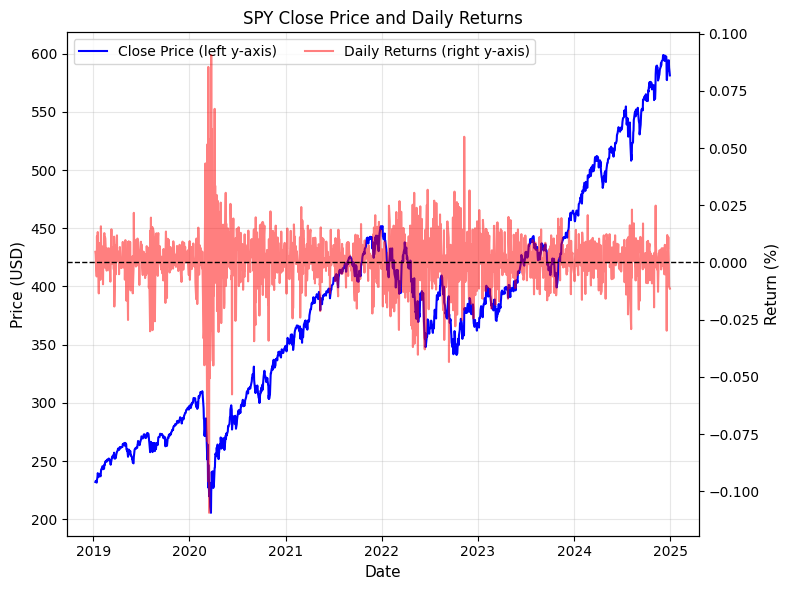


Observations:
- Returns fluctuate around 0 (positive = price went up, negative = price went down)
- Large spikes in returns indicate high volatility days
- Returns are more stationary than prices (don't trend upward)
- The trend can be upwards or downwards, but it is its fluctuations that determine the volatility


In [103]:
# Single figure
fig, ax_price = plt.subplots(figsize=(8, 6))

# Left y-axis: Close price
ax_price.plot(
    stock_data.index,
    stock_data['Close'],
    label='Close Price (left y-axis)',
    linewidth=1.5,
    color='blue'
)
ax_price.set_xlabel('Date', fontsize=11)
ax_price.set_ylabel('Price (USD)', fontsize=11)
ax_price.grid(alpha=0.3)

# Right y-axis: Daily returns
ax_return = ax_price.twinx()
ax_return.plot(
    stock_data.index,
    stock_data['Returns'],
    label='Daily Returns (right y-axis)',
    linewidth=1.5,
    alpha=0.5,
    color='red'
)
ax_return.axhline(y=0, linestyle='--', linewidth=1, color='black')
ax_return.set_ylabel('Return (%)', fontsize=11)

# Title
plt.title(f'{ticker} Close Price and Daily Returns', fontsize=12)

# Combined legend
lines_1, labels_1 = ax_price.get_legend_handles_labels()
lines_2, labels_2 = ax_return.get_legend_handles_labels()
ax_price.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print("\nObservations:")
print("- Returns fluctuate around 0 (positive = price went up, negative = price went down)")
print("- Large spikes in returns indicate high volatility days")
print("- Returns are more stationary than prices (don't trend upward)")
print("- The trend can be upwards or downwards, but it is its fluctuations that determine the volatility")


In [104]:
# Create *features* for volatility prediction
# These are technical indicators commonly used in quantitative finance
# Each feature captures a different aspect of market behavior that might predict future volatility
# The features will be used to train a model to predict future volatility (synonym to features are predictors, independent variables, input variables, etc.)
# More info on features: END OF NOTEBOOK

# Initialize features list: stores feature names (column names) that will be used for modeling
# For each feature: (1) append feature name to this list, (2) create the feature column in stock_data
features = []

# 1. Past returns (lagged 1 - 5 days)
# Rationale: Recent price movements may indicate future volatility (volatility clustering)
# If prices moved a lot recently, they might continue to be volatile
# Note: Including consecutive lags captures short-term dependencies
NL = 5   
for lag in range(1, NL + 1):
    features.append(f'Returns_lag_{lag}')
    stock_data[f'Returns_lag_{lag}'] = stock_data['Returns'].shift(lag)  # shift() moves data back in time

# 2. Absolute returns (volatility proxy)
# Rationale: Large price moves (regardless of direction) indicate high volatility
features.append('Abs_Returns')
stock_data['Abs_Returns'] = np.abs(stock_data['Returns'])

# 3. Volume features (normalized)
# Rationale: High trading volume often accompanies high volatility
# We normalize by 20-day average to make it comparable across time periods
features.append('Volume_norm')
stock_data['Volume_norm'] = stock_data['Volume'] / stock_data['Volume'].rolling(window=20).mean()

# 4. Price momentum (rate of change over different periods)
# Rationale: Strong trends (up or down) may be associated with different volatility regimes
# Momentum_5 = price change over 5 days, Momentum_10 = over 10 days, etc.
for period in [5, 10, 20]:
    features.append(f'Momentum_{period}')
    stock_data[f'Momentum_{period}'] = stock_data['Close'].pct_change(period)

# 5. Volatility features (rolling volatility over different windows)
# Rationale: Recent volatility is a strong predictor of future volatility (volatility clustering)
# This is like using the recent "variance" of returns to predict future variance
# IMPORTANT: We shift by 1 day to avoid data leakage - use only PAST volatility to predict FUTURE volatility
# Without shift: Volatility_5[t] includes return at time t (same as target) = DATA LEAKAGE!
# With shift: Volatility_5[t] uses returns up to time t-1 (past information only) = CORRECT!
for window in [5, 10, 20]:
    features.append(f'Volatility_{window}')
    # Calculate rolling volatility, then shift by 1 to use only past information
    stock_data[f'Volatility_{window}'] = stock_data['Returns'].rolling(window=window).std().shift(1)

# 6. High-Low range (normalized by close price)
# Rationale: Days with large intraday price swings (high-low range) indicate high volatility
# Normalized by close price to make it comparable across different price levels
features.append('HL_Range')
stock_data['HL_Range'] = (stock_data['High'] - stock_data['Low']) / stock_data['Close']

# 7. Price position (where close is relative to high-low range)
# Rationale: Where the price closes within the day's range may indicate market sentiment
# Values near 0 = closed near low (bearish), near 1 = closed near high (bullish)
features.append('Price_Position')
stock_data['Price_Position'] = (stock_data['Close'] - stock_data['Low']) / (stock_data['High'] - stock_data['Low'])

# Remove rows with NaN (created by lagged features and rolling calculations)
stock_data = stock_data.dropna()

print(f"After creating features: {len(stock_data)} days of data")
print(f"Number of features created: {len(features)}")

After creating features: 1484 days of data
Number of features created: 15


In [105]:
# Prepare feature matrix X and target y
feature_cols = [col for col in features if col in stock_data.columns]
X = stock_data[feature_cols].values
y = stock_data['Realized_Volatility'].values

print(f"\nFeature matrix shape: {X.shape}")
print(f"Number of features: {len(feature_cols)}")
print(f"Features used: {feature_cols}")

# Create 1 DataFrame for easier manipulation (all features and target in one place)
df = stock_data.copy()
df['target_volatility'] = y

# Print in a csv file for quick sanity check
# df.to_csv('stock_data_with_features.csv')


Feature matrix shape: (1484, 15)
Number of features: 15
Features used: ['Returns_lag_1', 'Returns_lag_2', 'Returns_lag_3', 'Returns_lag_4', 'Returns_lag_5', 'Abs_Returns', 'Volume_norm', 'Momentum_5', 'Momentum_10', 'Momentum_20', 'Volatility_5', 'Volatility_10', 'Volatility_20', 'HL_Range', 'Price_Position']


In [106]:

# For time series, we need to split chronologically (not randomly!)

# Use last 20% for testing to respect temporal order
TEST_SIZE = 0.200
split_idx = int(len(df) * (1 - TEST_SIZE))
X_train_full = X[:split_idx]
y_train_full = y[:split_idx]
X_test = X[split_idx:]
y_test = y[split_idx:]

print(f"\n" + "="*70)
print("DATA SPLIT SUMMARY")
print("="*70)
print(f"Full dataset shape: {X.shape}")
print(f"Training set shape: {X_train_full.shape} (first {split_idx} days)")
print(f"  Training period: {df.index[0].date()} to {df.index[split_idx-1].date()}")
print(f"Test set shape: {X_test.shape} (last {len(X_test)} days)")
print(f"  Test period: {df.index[split_idx].date()} to {df.index[-1].date()}")
print(f"\nRealized Volatility Statistics:")
print(f"  Training set - Mean: {y_train_full.mean():.4f}, Std: {y_train_full.std():.4f}")
print(f"  Training set - Min: {y_train_full.min():.4f}, Max: {y_train_full.max():.4f}")
print(f"  Test set - Mean: {y_test.mean():.4f}, Std: {y_test.std():.4f}")
print("="*70)



DATA SPLIT SUMMARY
Full dataset shape: (1484, 15)
Training set shape: (1187, 15) (first 1187 days)
  Training period: 2019-02-07 to 2023-10-24
Test set shape: (297, 15) (last 297 days)
  Test period: 2023-10-25 to 2024-12-30

Realized Volatility Statistics:
  Training set - Mean: 0.1674, Std: 0.1401
  Training set - Min: 0.0106, Max: 1.4023
  Test set - Mean: 0.1117, Std: 0.0528


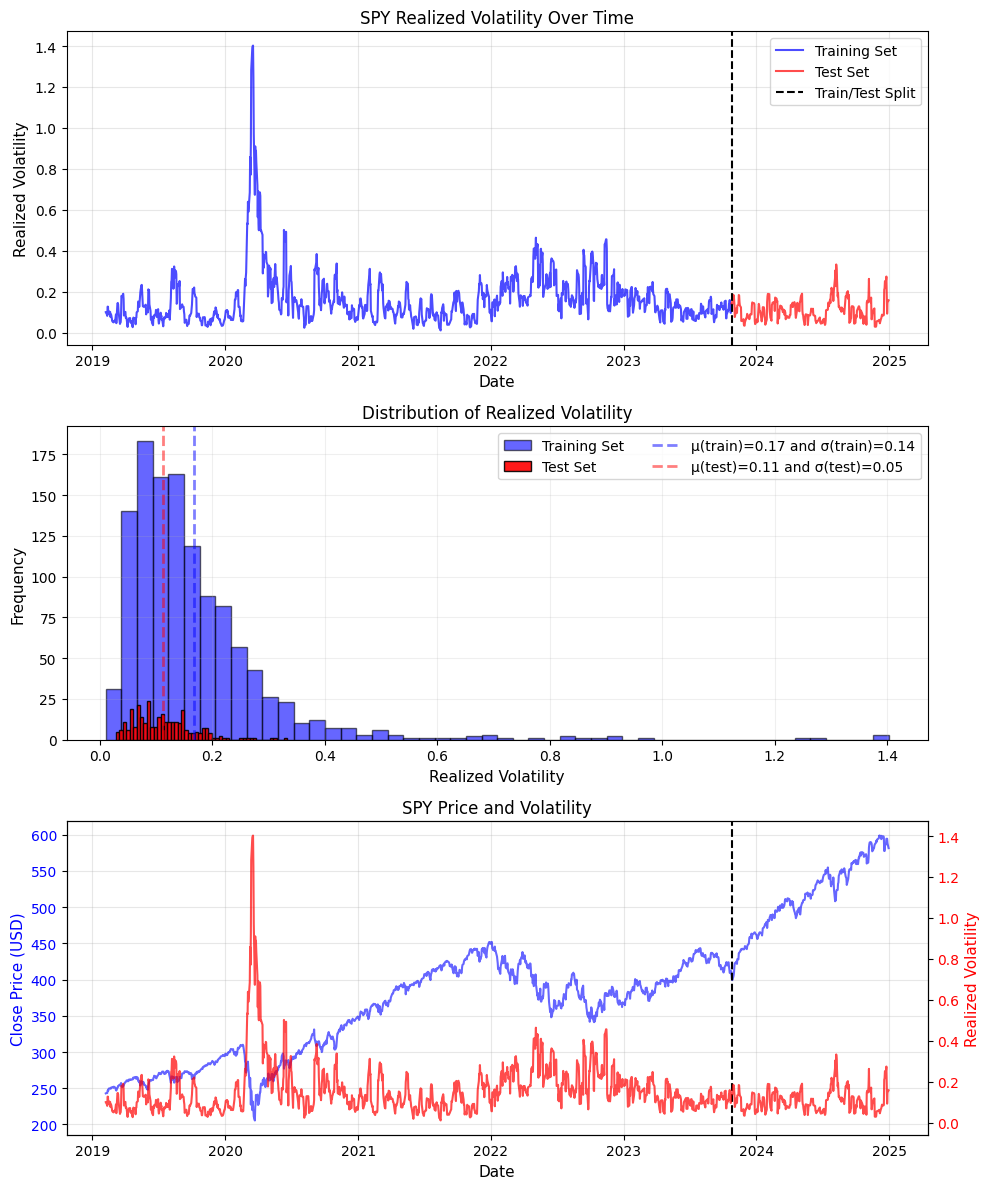


Key Observations:
- Volatility shows time-varying patterns (important for time series CV!)
- Distribution is right-skewed (common in financial data)
- Volatility clustering: periods of high volatility followed by high volatility
- Test set is chronologically after training set (no look-ahead bias)
- Using real SPY data from 2019-02-07 to 2024-12-30


In [139]:
# Visualize realized volatility over time 
from seaborn import boxenplot


fig, axes = plt.subplots(3, 1, figsize=(10, 12)) 

# Plot 1: Time series of realized volatility
axes[0].plot(df.index[:split_idx], y_train_full, label='Training Set', alpha=0.7, linewidth=1.5, color='blue') 
axes[0].plot(df.index[split_idx:], y_test, label='Test Set', alpha=0.7, linewidth=1.5, color='red') 
axes[0].axvline(x=df.index[split_idx], color='black', linestyle='--', linewidth=1.5, label='Train/Test Split') 
axes[0].set_title(f'{ticker} Realized Volatility Over Time', fontsize=12) 
axes[0].set_xlabel('Date', fontsize=11) 
axes[0].set_ylabel('Realized Volatility', fontsize=11) 
axes[0].legend() 
axes[0].grid(alpha=0.3) 

# Plot 2: Distribution of realized volatility 
axes[1].hist(y_train_full, bins=50, alpha=0.6, label='Training Set', color='blue', edgecolor='black') 
axes[1].hist(y_test, bins=50, alpha=0.9, label='Test Set', color='red', edgecolor='black') 
axes[1].axvline(y_train_full.mean(), color='blue', linestyle='--', linewidth=2, alpha=0.5, label=f'μ(train)={y_train_full.mean():.2f} and σ(train)={y_train_full.std():.2f}')
axes[1].axvline(y_test.mean(), color='red', linestyle='--', linewidth=2, alpha=0.5, label=f'μ(test)={y_test.mean():.2f} and σ(test)={y_test.std():.2f}')
axes[1].set_title('Distribution of Realized Volatility', fontsize=12) 
axes[1].set_xlabel('Realized Volatility', fontsize=11) 
axes[1].set_ylabel('Frequency', fontsize=11) 
axes[1].legend(ncol=2, bbox_to_anchor=(1, 1)) 
axes[1].grid(alpha=0.2)


# Plot 3: Price and volatility together
ax3_twin = axes[2].twinx()
axes[2].plot(df.index, df['Close'], label='Close Price', color='blue', alpha=0.6, linewidth=1.5)
ax3_twin.plot(df.index, df['Realized_Volatility'], label='Realized Volatility', color='red', alpha=0.7, linewidth=1.5)
axes[2].axvline(x=df.index[split_idx], color='black', linestyle='--', linewidth=1.5)
axes[2].set_xlabel('Date', fontsize=11)
axes[2].set_ylabel('Close Price (USD)', fontsize=11, color='blue')
ax3_twin.set_ylabel('Realized Volatility', fontsize=11, color='red')
axes[2].set_title(f'{ticker} Price and Volatility', fontsize=12)
axes[2].tick_params(axis='y', labelcolor='blue')
ax3_twin.tick_params(axis='y', labelcolor='red')
axes[2].grid(alpha=0.3)
 
plt.tight_layout() 
plt.show() 
 
print(f"\nKey Observations:") 
print(f"- Volatility shows time-varying patterns (important for time series CV!)")
print(f"- Distribution is right-skewed (common in financial data)")
print(f"- Volatility clustering: periods of high volatility followed by high volatility")
print(f"- Test set is chronologically after training set (no look-ahead bias)")
print(f"- Using real {ticker} data from {df.index[0].date()} to {df.index[-1].date()}") 

## 3. Understanding Cross-Validation for Time Series 
 
Cross-validation helps us: 
- Get more reliable performance estimates 
- Use all data for both training and validation 
- Reduce variance in performance estimates 
- Better assess model generalization 

### Why Time Series Data is Different

In finance, **temporal order matters critically**:
- **Volatility Clustering**: Periods of high volatility tend to be followed by high volatility (and vice versa)
- **Market Regimes**: Markets go through different "regimes" (bull markets, bear markets, crises) that persist over time
- **Information Flow**: News and events affect prices in sequence - you can't use tomorrow's news to predict today

**Analogy for Engineers**: Think of it like predicting turbulence intensity (TKE - Turbulent Kinetic Energy) in a flow field. If you're predicting turbulence at time t, you can only use measurements from times before t (t-1, t-2, etc.). You can't use future turbulence measurements (t+1, t+2) to predict past turbulence - that would be like having a time machine! Just as turbulence clusters in space and time (high TKE regions followed by high TKE regions), volatility clusters in financial time series.

### 3.1 Time Series Cross-Validation vs Standard K-Fold 
 
**WARNING: CRITICAL for Financial Data:** 
- **Standard K-Fold**: Randomly shuffles data (WRONG for time series!) 
  - This would use data from 2024 to predict 2020 - impossible in real trading!
- **Time Series Split**: Respects temporal order (CORRECT for financial data) 
  - Always uses past data to predict future - realistic trading scenario
  - Uses expanding window: Fold 1 trains on period 1, tests on 2; Fold 2 trains on periods 1-2, tests on 3, etc.
- **Why it matters**: Financial data has temporal dependencies; using future data to predict past creates **look-ahead bias** (using information you wouldn't have in real trading) 
 
### 3.2 Choosing the Right K Value 
 
**Key considerations:** 
- **Small k (e.g., k=3, k=5)**: More training data per fold (lower bias), but fewer validation sets (higher variance in performance estimates) 
- **Large k (e.g., k=10, k=20)**: More validation sets (lower variance in estimates), but less training data per fold (higher bias)
- **For time series**: Each fold must contain enough data to capture temporal patterns and market cycles (typically 6-12 months minimum for financial data)
 
**Common choices:** 
- **k=5**: Good for financial data with limited history; balances training size with validation robustness
- **k=10**: Standard default for larger datasets with sufficient historical data
- **TimeSeriesSplit**: Essential for financial/volatility prediction to maintain temporal integrity

**Example for 5 years of data with k=5:**
- Fold 1: Train on Year 1 → Test on Year 2
- Fold 2: Train on Years 1-2 → Test on Year 3
- Fold 3: Train on Years 1-3 → Test on Year 4
- Fold 4: Train on Years 1-4 → Test on Year 5

Time Series Split = f(K folds)

k=5:
 TimeSeriesSplit RMSE: 0.1158 (σ: ±0.0877)

k=10:
 TimeSeriesSplit RMSE: 0.1046 (σ: ±0.0938)

k=15:
 TimeSeriesSplit RMSE: 0.1023 (σ: ±0.0977)

k=20:
 TimeSeriesSplit RMSE: 0.0993 (σ: ±0.1022)


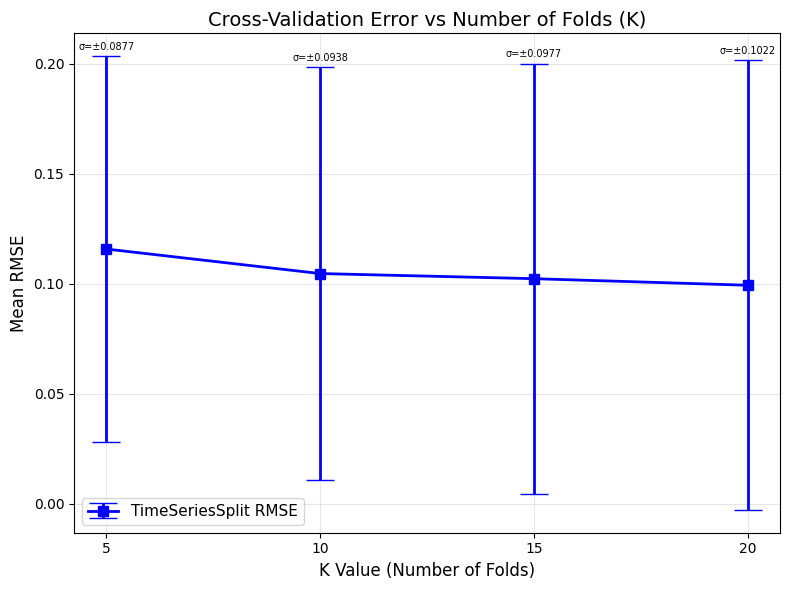


Key Observations:
- As k increases, we get more validation estimates (lower estimation bias)
- However, each fold has less training data → higher model bias (especially early folds)
- Individual fold estimates become noisier → higher estimation variance
- The optimal k balances bias and variance for your specific dataset


In [157]:
# Compare different k values using TimeSeriesSplit (correct for time series) 

"""
EFFECT OF K VALUE ON TIME SERIES CROSS-VALIDATION:

LOW K (e.g., k=3, k=5):
  ADVANTAGES: More training data per fold → Better model learning (lower bias)
  ADVANTAGES: More stable fold estimates, faster computation
  DISADVANTAGES: Fewer validation samples → Higher estimation bias, less robust assessment

HIGH K (e.g., k=15, k=20):
  ADVANTAGES: More validation samples → Lower estimation bias, better statistical assessment
  DISADVANTAGES: Less training data per fold → Higher model bias, especially in early folds
  DISADVANTAGES: Early folds may have insufficient data, higher variance in estimates

BIAS-VARIANCE TRADEOFF:
  - Low k: Lower model bias, higher estimation bias, lower estimation variance
  - High k: Higher model bias (early folds), lower estimation bias, higher estimation variance
  - Goal: Minimize total error = bias² + variance
  
  Note: Why is bias squared? In the mathematical derivation of expected prediction error,
  the bias-variance decomposition yields: E[(prediction - true)²] = bias² + variance + irreducible_error
  The squared form comes from expanding the squared error term. See Appendix for detailed explanation.

RECOMMENDED: k = 5 to 10 for most financial/time series applications
  - Ensure minimum training data per fold (6-12 months minimum)
  - Balance model learning vs. performance assessment
  - See Appendix for detailed explanation
"""

k_values = [5, 10, 15, 20]

# Initialize empty dictionary to store results
cv_results_ts = {} 


# Use a simple model with fixed hyperparameters to compare k values (hyperparameter tuning comes later)

# Ridge regression (L2-norm)
#  This model solves a regression model where the loss function is the linear least squares function and regularization is given by the l2-norm. 
#  Also known as *Ridge Regression* or *Tikhonov regularization*.
#  i.e., training a model with Ridge regression is equivalent to minimizing the following loss function:
#  loss = (y - Xw)^2 + alpha * w^2
#  where y is the target variable, X is the feature matrix, w is the weight vector, and alpha is the regularization parameter.
model = Ridge(alpha=1.0)

# Alternatively, you can use Lasso regression (L1-norm) or Elastic Net (L1+L2-norm)

# Lasso regression (L1-norm)
#  loss = (y - Xw)^2 + alpha * |w|
#  where y is the target variable, X is the feature matrix, w is the weight vector, and alpha is the regularization parameter.
'''model = Lasso(alpha=1.0)'''

# Elastic Net (L1+L2-norm)
#  loss = (y - Xw)^2 + alpha * (l1_ratio * |w| + (1 - l1_ratio) * w^2)  
'''model = ElasticNet(alpha=1.0, l1_ratio=0.5)'''

print("="*70) 
print("Time Series Split = f(K folds)") 
print("="*70) 
 
for k in k_values: 
 # Time Series Split (CORRECT for financial data) 
 tscv = TimeSeriesSplit(n_splits=k) 
 scores_ts = cross_val_score(model, X_train_full, y_train_full, 
 cv=tscv, scoring='neg_mean_squared_error') 
 scores_ts = np.sqrt(-scores_ts) # Convert to RMSE 
 cv_results_ts[k] = { 
 'mean': scores_ts.mean(), 
 'std': scores_ts.std(), 
 'scores': scores_ts 
 } 
 
 print(f"\nk={k}:") 
 print(f" TimeSeriesSplit RMSE: {scores_ts.mean():.4f} (σ: ±{scores_ts.std():.4f})")

# Plot k vs error
means = [cv_results_ts[k]['mean'] for k in k_values]
stds = [cv_results_ts[k]['std'] for k in k_values]

fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(k_values, means, yerr=stds, fmt='s-', capsize=10, linewidth=2, markersize=7, color='blue', label='TimeSeriesSplit RMSE')
ax.set_xlabel('K Value (Number of Folds)', fontsize=12)
ax.set_xticks(k_values)
ax.set_ylabel('Mean RMSE', fontsize=12)
ax.set_title('Cross-Validation Error vs Number of Folds (K)', fontsize=14)
ax.grid(alpha=0.3)
ax.legend(fontsize=11)

# Add value labels on points
for k, mean, std in zip(k_values, means, stds):
    ax.text(k, mean + std + 0.002, f'σ=±{std:.4f}', 
            ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Key Observations:")
print("="*70)
print("- As k increases, we get more validation estimates (lower estimation bias)")
print("- However, each fold has less training data → higher model bias (especially early folds)")
print("- Individual fold estimates become noisier → higher estimation variance")
print("- The optimal k balances bias and variance for your specific dataset")
print("="*70) 


## 4. Time Series Cross-Validation
 
### Time Series Cross-Validation
 
**Solution**: Use **TimeSeriesSplit** which respects temporal order: 
- Each fold uses only past data to predict future 
- Training set always comes before test set chronologically 
- More realistic performance estimates 
- Mimics real-world prediction scenario 
 
### Why This Matters for Volatility Prediction 
 
- Volatility has **temporal dependencies** (volatility clustering) 
- Using future information creates unrealistic performance 
- In production, you can only use historical data to predict future volatility

**Note**: For detailed explanation of why standard K-Fold is incorrect for time series, see the Appendix section on "Common Pitfalls: Standard K-Fold for Time Series".


VISUALIZING: TimeSeriesSplit - Respects Temporal Order


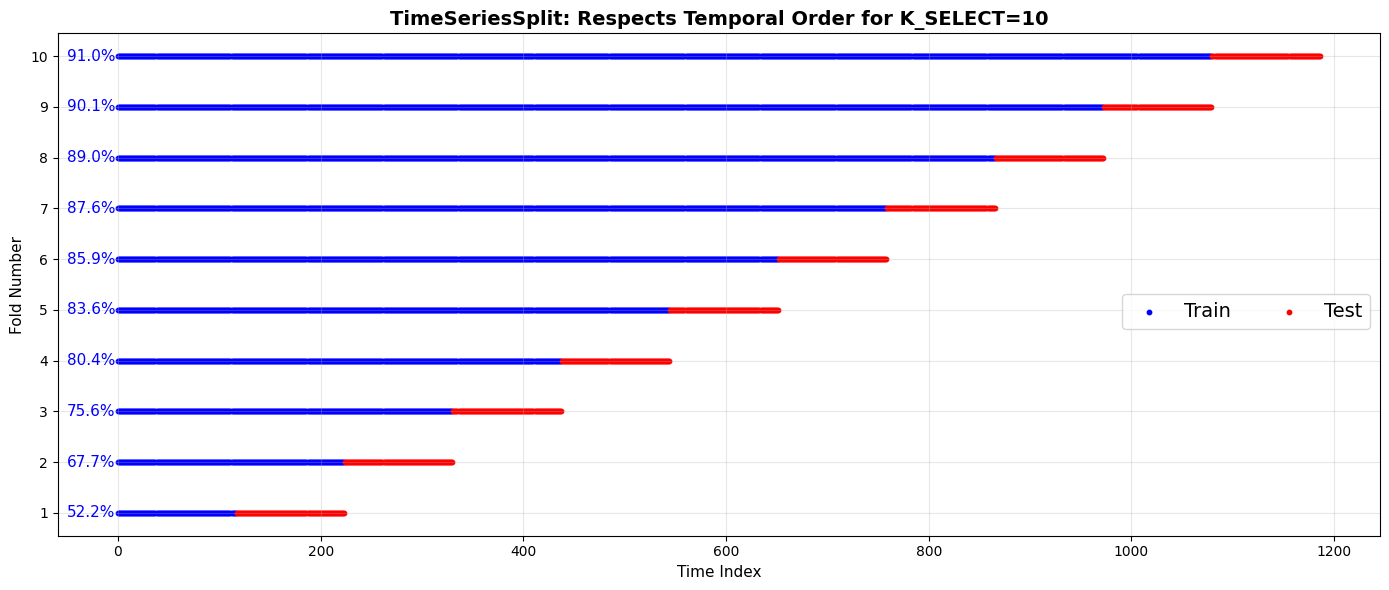


Key Insight:
TimeSeriesSplit ensures training data always comes BEFORE test data
Each fold uses only past data to predict future - realistic trading scenario


In [184]:
# Demonstration: Visualizing TimeSeriesSplit
print("="*70) 
print("VISUALIZING: TimeSeriesSplit - Respects Temporal Order") 
print("="*70) 
 
K_SELECT = 10   
# Create a visualization of how TimeSeriesSplit creates folds
fig, ax = plt.subplots(figsize=(14, 6)) 

tscv = TimeSeriesSplit(n_splits=K_SELECT) 
for i, (train_idx, test_idx) in enumerate(tscv.split(X_train_full)): 
 train_times = np.arange(len(X_train_full))[train_idx] 
 test_times = np.arange(len(X_train_full))[test_idx] 
 ax.scatter(train_times, [i+1]*len(train_times), c='blue', alpha=1, s=10, label='Train' if i==0 else '') 
 ax.scatter(test_times, [i+1]*len(test_times), c='red', alpha=1, s=10, label='Test' if i==0 else '')
 
 # Calculate and display percentage of data used for training in this fold
 percentage_of_data_used_for_training_vs_testing = (len(train_idx)) / (len(train_idx) + len(test_idx)) * 100
 ax.text(-len(X_train_full) * 0.0425, i+1, f'{percentage_of_data_used_for_training_vs_testing:.1f}%', 
         fontsize=11, color='blue', horizontalalignment='left', verticalalignment='center')
 
ax.set_title(f'TimeSeriesSplit: Respects Temporal Order for K_SELECT={K_SELECT}', fontsize=14, fontweight='bold') 
ax.set_xlabel('Time Index', fontsize=11) 
ax.set_ylabel('Fold Number', fontsize=11) 
ax.set_yticks(range(1, K_SELECT+1)) 
ax.legend(ncol=2,  bbox_to_anchor=(1, 0.5), fontsize=14) 
ax.grid(alpha=0.3) 
 
plt.tight_layout() 
plt.show() 
 
print("\nKey Insight:") 
print("TimeSeriesSplit ensures training data always comes BEFORE test data")
print("Each fold uses only past data to predict future - realistic trading scenario")


## 5. Combining Cross-Validation with Hyperparameter Tuning 

----(THE MATERIALS HAVE BEEN COVER UP TO HERE)----
 
When tuning hyperparameters for volatility prediction, we need to: 
1. Use **TimeSeriesSplit** cross-validation to evaluate different hyperparameter combinations 
2. Respect temporal order (no look-ahead bias) 
3. Use appropriate regression metrics (RMSE, MAE, R²) for volatility prediction 
4. Scale features appropriately (volatility features may have different scales) 
 
### 5.1 Hyperparameter Tuning with GridSearchCV


In [123]:
# Define hyperparameter grid for Ridge regression 
param_grid = { 
 'regressor__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 
} 
 
# Create pipeline with scaling and regressor 
# Scaling is important for volatility prediction (features may have different scales) 
pipeline = Pipeline([ 
 ('scaler', StandardScaler()), 
 ('regressor', Ridge(random_state=42)) 
]) 
 
# Use TimeSeriesSplit for cross-validation (CRITICAL for time series!) 
tscv = TimeSeriesSplit(n_splits=5) 
 
# GridSearchCV with cross-validation 
# Note: For regression, we use 'neg_mean_squared_error' (negative because GridSearchCV maximizes) 
# We'll convert to RMSE for interpretation 
print("Performing GridSearchCV with TimeSeriesSplit...") 
print("This may take a moment...\n") 
 
grid_search = GridSearchCV( 
 pipeline, 
 param_grid, 
 cv=tscv, 
 scoring='neg_mean_squared_error', # Negative MSE (higher is better for GridSearchCV) 
 n_jobs=-1, 
 verbose=1 
) 
 
grid_search.fit(X_train_full, y_train_full) 
 
# Convert best score to RMSE for interpretation 
best_rmse = np.sqrt(-grid_search.best_score_) 
 
print(f"\nBest parameters: {grid_search.best_params_}") 
print(f"Best cross-validation RMSE: {best_rmse:.4f}") 
print(f"Best cross-validation MSE: {-grid_search.best_score_:.6f}")


Performing GridSearchCV with TimeSeriesSplit...
This may take a moment...

Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best parameters: {'regressor__alpha': 1.0}
Best cross-validation RMSE: 0.0407
Best cross-validation MSE: 0.001659


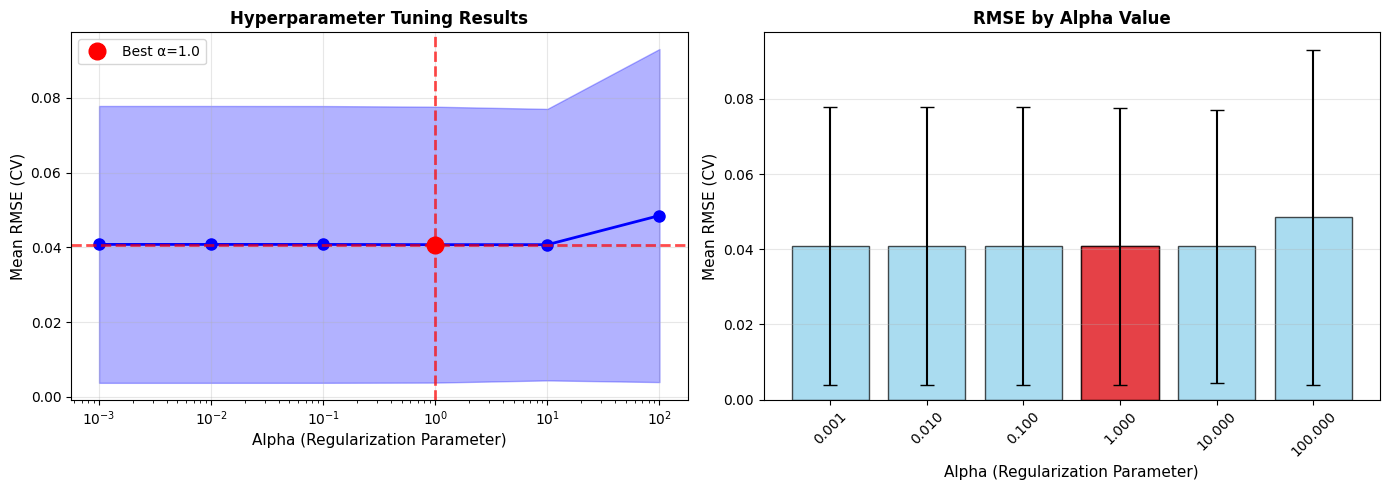


Best alpha: 1.0
Best RMSE: 0.0407

 Lower alpha = less regularization (more complex model)
 Higher alpha = more regularization (simpler model, prevents overfitting)


In [111]:
# Visualize hyperparameter search results 
results_df = pd.DataFrame(grid_search.cv_results_) 
 
# Extract alpha values and convert scores to RMSE 
results_df['alpha'] = results_df['param_regressor__alpha'] 
results_df['rmse'] = np.sqrt(-results_df['mean_test_score']) 
results_df['std_rmse'] = np.sqrt(results_df['std_test_score']) 
 
# Plot results 
fig, axes = plt.subplots(1, 2, figsize=(14, 5)) 
 
# Plot 1: RMSE vs Alpha 
axes[0].plot(results_df['alpha'], results_df['rmse'], 
 marker='o', linewidth=2, markersize=8, color='blue') 
axes[0].fill_between(results_df['alpha'], 
 results_df['rmse'] - results_df['std_rmse'], 
 results_df['rmse'] + results_df['std_rmse'], 
 alpha=0.3, color='blue') 
axes[0].set_xscale('log') 
axes[0].set_xlabel('Alpha (Regularization Parameter)', fontsize=11) 
axes[0].set_ylabel('Mean RMSE (CV)', fontsize=11) 
axes[0].set_title('Hyperparameter Tuning Results', fontsize=12, fontweight='bold') 
axes[0].grid(alpha=0.3) 
 
# Mark best parameter 
best_alpha = grid_search.best_params_['regressor__alpha'] 
best_rmse = results_df[results_df['alpha'] == best_alpha]['rmse'].values[0] 
axes[0].axvline(x=best_alpha, color='red', linestyle='--', alpha=0.7, linewidth=2) 
axes[0].axhline(y=best_rmse, color='red', linestyle='--', alpha=0.7, linewidth=2) 
axes[0].plot(best_alpha, best_rmse, 'ro', markersize=12, label=f'Best α={best_alpha}') 
axes[0].legend() 
 
# Plot 2: Bar chart showing RMSE for each alpha 
axes[1].bar(range(len(results_df)), results_df['rmse'], 
 yerr=results_df['std_rmse'], capsize=5, 
 color='skyblue', edgecolor='black', alpha=0.7) 
axes[1].set_xticks(range(len(results_df))) 
axes[1].set_xticklabels([f'{a:.3f}' for a in results_df['alpha']], rotation=45) 
axes[1].set_xlabel('Alpha (Regularization Parameter)', fontsize=11) 
axes[1].set_ylabel('Mean RMSE (CV)', fontsize=11) 
axes[1].set_title('RMSE by Alpha Value', fontsize=12, fontweight='bold') 
axes[1].grid(axis='y', alpha=0.3) 
 
# Highlight best 
best_idx = results_df['rmse'].idxmin() 
axes[1].bar(best_idx, results_df.loc[best_idx, 'rmse'], 
 color='red', edgecolor='black', alpha=0.7) 
 
plt.tight_layout() 
plt.show() 
 
print(f"\nBest alpha: {best_alpha}") 
print(f"Best RMSE: {best_rmse:.4f}") 
print(f"\n Lower alpha = less regularization (more complex model)") 
print(f" Higher alpha = more regularization (simpler model, prevents overfitting)")


### 5.2 Evaluating with Multiple Regression Metrics 
 
For volatility prediction, we need multiple metrics to assess model performance. Each metric tells us something different:

- **RMSE (Root Mean Squared Error)**: Penalizes large errors more (important for risk management)
  - *Finance context*: Large volatility prediction errors are dangerous - underestimating volatility can lead to insufficient risk capital. RMSE heavily penalizes these dangerous errors.
  - *Interpretation*: If RMSE = 0.15, typical prediction error is ~15% (annualized volatility units)
  
- **MAE (Mean Absolute Error)**: Average prediction error
  - *Finance context*: Gives equal weight to all errors, regardless of size. Useful for understanding typical prediction accuracy.
  - *Interpretation*: Average absolute error in volatility prediction
  
- **R² (R-squared)**: Proportion of variance explained
  - *Finance context*: How much of the volatility variation can we explain? R² = 0.5 means we explain 50% of volatility movements.
  - *Interpretation*: R² = 1.0 is perfect, R² = 0.0 means model is no better than predicting the mean. For volatility, R² > 0.3 is often considered good (volatility is inherently hard to predict).
  
- **MAPE (Mean Absolute Percentage Error)**: Relative error (useful for volatility)
  - *Finance context*: Percentage error is more interpretable than absolute error. A 0.1 error when volatility is 0.2 (50% error) is worse than when volatility is 0.5 (20% error).
  - *Interpretation*: Average percentage error in predictions


In [112]:
# Evaluate best model on test set with multiple metrics 
try:
    best_model = grid_search.best_estimator_ 
    y_pred = best_model.predict(X_test)
except NameError:
    raise NameError("grid_search is not defined. Please run the GridSearchCV cell (Cell 16) first.")
except AttributeError:
    raise AttributeError("grid_search has not been fitted yet. Please run grid_search.fit() in Cell 16 first.")
except Exception as e:
    raise Exception(f"Error accessing grid_search: {e}. Make sure Cell 16 has been executed successfully.") 
 
# Calculate multiple regression metrics 
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) 
mae = mean_absolute_error(y_test, y_pred) 
r2 = r2_score(y_test, y_pred) 
mape = mean_absolute_percentage_error(y_test, y_pred) 
 
metrics = { 
 'RMSE': rmse, 
 'MAE': mae, 
 'R²': r2, 
 'MAPE (%)': mape * 100 
} 
 
print("="*70) 
print("Final Model Performance on Test Set") 
print("="*70) 
for metric_name, metric_value in metrics.items(): 
    if metric_name == 'MAPE (%)': 
        print(f"{metric_name:15s}: {metric_value:.2f}%") 
    else: 
        print(f"{metric_name:15s}: {metric_value:.4f}") 
 
print("\n" + "="*70)
print("Interpretation:")
print("="*70)
print(f"RMSE: {rmse:.4f} - Average prediction error (penalizes large errors)")
print(f"  Finance context: If volatility is typically 0.20 (20% annualized), an RMSE of {rmse:.4f} means")
if 0.20 > 0:
    print(f"  we're typically off by {rmse/0.20*100:.1f}% of typical volatility levels")
else:
    print(f"  we're typically off by {rmse*100:.1f}% of typical volatility levels")
print(f"\nMAE: {mae:.4f} - Average absolute error")
print(f"  Finance context: On average, our predictions are off by {mae:.4f} volatility units")
print(f"\nR²: {r2:.4f} - {r2*100:.1f}% of variance in volatility is explained by the model")
if r2 > 0.5:
    print(f"  Finance context: Good! We explain more than half of volatility movements")
elif r2 > 0.3:
    print(f"  Finance context: Reasonable for volatility prediction (volatility is inherently hard to predict)")
else:
    print(f"  Finance context: Low - volatility is very difficult to predict, this may be normal")
print(f"\nMAPE: {mape*100:.2f}% - Average percentage error")
print(f"  Finance context: On average, predictions are off by {mape*100:.2f}% relative to actual volatility")
print("="*70)


Final Model Performance on Test Set
RMSE           : 0.0244
MAE            : 0.0173
R²             : 0.7874
MAPE (%)       : 19.35%

Interpretation:
RMSE: 0.0244 - Average prediction error (penalizes large errors)
  Finance context: If volatility is typically 0.20 (20% annualized), an RMSE of 0.0244 means
  we're typically off by 12.2% of typical volatility levels

MAE: 0.0173 - Average absolute error
  Finance context: On average, our predictions are off by 0.0173 volatility units

R²: 0.7874 - 78.7% of variance in volatility is explained by the model
  Finance context: Good! We explain more than half of volatility movements

MAPE: 19.35% - Average percentage error
  Finance context: On average, predictions are off by 19.35% relative to actual volatility


In [113]:
# Visualize predictions and metrics 
fig, axes = plt.subplots(2, 2, figsize=(16, 12)) 
 
# Plot 1: Actual vs Predicted 
ax1 = axes[0, 0] 
ax1.scatter(y_test, y_pred, alpha=0.6, s=50) 
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
 'r--', linewidth=2, label='Perfect Prediction') 
ax1.set_xlabel('Actual Realized Volatility', fontsize=11) 
ax1.set_ylabel('Predicted Realized Volatility', fontsize=11) 
ax1.set_title('Actual vs Predicted Volatility', fontsize=12, fontweight='bold') 
ax1.legend() 
ax1.grid(alpha=0.3) 
 
# Plot 2: Residuals 
ax2 = axes[0, 1] 
residuals = y_test - y_pred 
ax2.scatter(y_pred, residuals, alpha=0.6, s=50) 
ax2.axhline(y=0, color='r', linestyle='--', linewidth=2) 
ax2.set_xlabel('Predicted Realized Volatility', fontsize=11) 
ax2.set_ylabel('Residuals (Actual - Predicted)', fontsize=11) 
ax2.set_title('Residual Plot', fontsize=12, fontweight='bold') 
ax2.grid(alpha=0.3) 
 
# Plot 3: Time series of predictions 
ax3 = axes[1, 0] 
test_dates = df.index[split_idx:] 
ax3.plot(test_dates, y_test, label='Actual', linewidth=2, alpha=0.7) 
ax3.plot(test_dates, y_pred, label='Predicted', linewidth=2, alpha=0.7, linestyle='--') 
ax3.set_xlabel('Date', fontsize=11) 
ax3.set_ylabel('Realized Volatility', fontsize=11) 
ax3.set_title('Time Series: Actual vs Predicted', fontsize=12, fontweight='bold') 
ax3.legend() 
ax3.grid(alpha=0.3) 
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45) 
 
# Plot 4: Metrics bar chart 
ax4 = axes[1, 1] 
metric_names = ['RMSE', 'MAE', 'R²', 'MAPE (%)'] 
metric_values = [metrics['RMSE'], metrics['MAE'], metrics['R²'], metrics['MAPE (%)']] 
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold'] 
bars = ax4.bar(metric_names, metric_values, color=colors, edgecolor='black', linewidth=1.5) 
ax4.set_ylabel('Value', fontsize=11) 
ax4.set_title('Model Performance Metrics', fontsize=12, fontweight='bold') 
ax4.grid(axis='y', alpha=0.3) 
 
# Add value labels 
for bar, value, name in zip(bars, metric_values, metric_names): 
 if name == 'MAPE (%)': 
 label = f'{value:.2f}%' 
 elif name == 'R²': 
 label = f'{value:.4f}' 
 else: 
 label = f'{value:.4f}' 
 ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(metric_values)*0.02, 
 label, ha='center', va='bottom', fontweight='bold') 
 
plt.tight_layout() 
plt.show() 
 
print("\n Key Insights:") 
print(" - R² close to 1.0 indicates good fit") 
print(" - Residuals should be randomly distributed (no patterns)") 
print(" - Predictions should track actual volatility over time")


IndentationError: expected an indented block after 'if' statement on line 49 (840040939.py, line 50)

## 6. Complete Workflow: Putting It All Together 
 
Here's the correct workflow for hyperparameter tuning with cross-validation for volatility prediction: 
 
### Step-by-Step Process: 
 
1. **Chronological Split**: Split data into train and test sets **chronologically** (test set is locked away!) 
2. **Cross-Validation Setup**: Choose k (typically 5 or 10) and use **TimeSeriesSplit** 
3. **Pipeline Creation**: Create a pipeline with scaling and regressor 
4. **Hyperparameter Tuning**: Use GridSearchCV or RandomizedSearchCV 
 - TimeSeriesSplit ensures temporal order is respected 
5. **Model Selection**: Choose best model based on CV scores (RMSE, MAE, R²) 
6. **Final Evaluation**: Test on held-out test set (only once!) 
 
### Key Principles: 
 
 **DO:** 
- Use TimeSeriesSplit for financial/time series data 
- Split data chronologically (not randomly) 
- Scale features appropriately 
- Use appropriate regression metrics (RMSE, MAE, R²) 
- Keep test set completely separate until final evaluation 
 
 **DON'T:** 
- Use standard K-Fold with shuffling for time series 
- Split data randomly (creates look-ahead bias) 
- Use test set for hyperparameter tuning 
- Rely only on one metric 
- Ignore temporal dependencies


In [ ]:
# Complete workflow demonstration 
print("="*70) 
print("COMPLETE WORKFLOW SUMMARY") 
print("="*70) 
 
print("\n1. DATA SPLITTING (Chronological):") 
print(f" - Training set: {X_train_full.shape[0]} samples (first {split_idx} days)") 
print(f" - Test set: {X_test.shape[0]} samples (last {len(X_test)} days)") 
print(" - Split is CHRONOLOGICAL (no look-ahead bias)") 
 
print("\n2. CROSS-VALIDATION SETUP:") 
print(" - Method: TimeSeriesSplit (respects temporal order)") 
print(" - K value: 5 folds") 
print(" - Each fold uses only past data to predict future") 
 
print("\n3. HYPERPARAMETER TUNING:") 
print(f" - Best alpha: {grid_search.best_params_['regressor__alpha']}") 
print(f" - Best CV RMSE: {best_rmse:.4f}") 
print(" - Tuned using TimeSeriesSplit (realistic performance)") 
 
print("\n4. FINAL EVALUATION:") 
print(f" - Test set RMSE: {metrics['RMSE']:.4f}") 
print(f" - Test set MAE: {metrics['MAE']:.4f}") 
print(f" - Test set R²: {metrics['R²']:.4f}") 
print(f" - Test set MAPE: {metrics['MAPE (%)']:.2f}%") 
 
print("\n" + "="*70) 
print(" Workflow completed successfully!") 
print("="*70)


## 7. Reflection Questions 
 
Based on the exercise requirements, adapted for realized volatility prediction: 
 
### Question 1: Is your dataset likely to have temporal dependencies? 
 
**For volatility prediction:** 
- Financial time series have **strong temporal dependencies** 
- Volatility clustering: high volatility periods followed by high volatility 
- Market regimes change over time 
- Random splitting would break these dependencies 
 
**Why temporal order matters for hyperparameter tuning:** 
- Without respecting temporal order, models see future information 
- Hyperparameter tuning on shuffled data optimizes for unrealistic scenarios 
- TimeSeriesSplit ensures realistic performance estimates 
 
### Question 2: How could proper cross-validation help focus on realistic performance? 
 
**Key benefits:** 
- **Realistic estimates**: Model performance matches production conditions 
- **No look-ahead bias**: Only uses past data to predict future 
- **Better risk management**: Accurate volatility predictions are critical for risk 
- **Fair evaluation**: Metrics reflect true model capability 
 
### Question 3: When should time series cross-validation be applied? 
 
** CORRECT: TimeSeriesSplit** 
- Respects temporal order in each CV fold 
- Training data always comes before test data chronologically 
- Prevents look-ahead bias 
- More realistic performance estimates 
 
** WRONG: Standard K-Fold with shuffling** 
- Shuffles data randomly 
- Creates look-ahead bias (future data predicts past) 
- Overly optimistic results 
- Unreliable performance estimates 
 
### Question 4: What problems arise from incorrect cross-validation? 
 
**Look-Ahead Bias:** 
- Model uses future information to predict past 
- Performance metrics become inflated and unreliable 
- Model won't work in production (can't use future data!) 
 
**Temporal Dependency Violation:** 
- Breaks natural time series structure 
- Model learns unrealistic patterns 
- Poor generalization to real trading scenarios 
 
**Impact on Trust:** 
- Results cannot be trusted for production 
- Model may fail in live trading 
- Wasted time and resources 
- Potential financial losses 
 
### Question 5: Workflow Plan 
 
**Recommended workflow for volatility prediction:** 
1. **Chronological Split**: Train/Test split respecting time order 
2. **Lock Test Set**: Never touch until final evaluation 
3. **Cross-Validation Setup**: 
 - Choose k (5 or 10 typically) 
 - Use **TimeSeriesSplit** (not standard K-Fold!) 
4. **Create Pipeline**: 
 - Step 1: Feature scaling (StandardScaler) 
 - Step 2: Regressor (Ridge, Lasso, Random Forest, etc.) 
5. **Hyperparameter Tuning**: 
 - Use GridSearchCV/RandomizedSearchCV 
 - TimeSeriesSplit ensures temporal order in each fold 
 - Use appropriate regression metrics (RMSE, MAE, R²) 
6. **Model Selection**: Choose best based on CV scores 
7. **Final Evaluation**: Test on held-out test set once 
 
### Question 6: How to test generalization? 
 
**Final Evaluation Steps:** 
1. **Test Set Evaluation**: Use completely untouched test set (chronologically after training) 
2. **Compare Metrics**: CV scores vs test scores should be similar 
3. **Check for Overfitting**: Large gap between CV and test = overfitting 
4. **Multiple Metrics**: Don't rely on one metric (use RMSE, MAE, R², MAPE) 
5. **Residual Analysis**: Check if residuals are random (no patterns) 
6. **Time Series Plot**: Visualize predictions vs actual over time 
7. **If Overfitting Detected**: 
 - Increase regularization (higher alpha) 
 - Reduce model complexity 
 - Get more data 
 - Re-evaluate feature engineering 
 - Consider ensemble methods


In [ ]:
# Compare CV performance vs Test performance 
print("="*70) 
print("GENERALIZATION CHECK: CV vs Test Performance") 
print("="*70) 
 
# Get CV scores from best model 
best_cv_rmse = best_rmse 
test_rmse = metrics['RMSE'] 
test_mae = metrics['MAE'] 
test_r2 = metrics['R²'] 
 
print(f"\nCross-Validation RMSE: {best_cv_rmse:.4f}") 
print(f"Test Set RMSE: {test_rmse:.4f}") 
print(f"Difference: {abs(best_cv_rmse - test_rmse):.4f}") 
 
print(f"\nTest Set MAE: {test_mae:.4f}") 
print(f"Test Set R²: {test_r2:.4f}") 
 
# Visualize comparison 
fig, ax = plt.subplots(figsize=(10, 6)) 
metrics_to_compare = ['CV RMSE', 'Test RMSE', 'Test MAE'] 
values_to_compare = [best_cv_rmse, test_rmse, test_mae] 
colors = ['skyblue', 'lightgreen', 'coral'] 
 
bars = ax.bar(metrics_to_compare, values_to_compare, color=colors, 
 edgecolor='black', linewidth=2, alpha=0.7) 
ax.set_ylabel('Error (Lower is Better)', fontsize=12) 
ax.set_title('Generalization Check: CV vs Test Performance', fontsize=14, fontweight='bold') 
ax.grid(axis='y', alpha=0.3) 
 
# Add value labels 
for bar, value in zip(bars, values_to_compare): 
 ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values_to_compare)*0.02, 
 f'{value:.4f}', ha='center', va='bottom', fontweight='bold') 
 
# Add interpretation 
gap = abs(best_cv_rmse - test_rmse) 
relative_gap = gap / best_cv_rmse 
if relative_gap < 0.1: 
 interpretation = " Good generalization! CV and test scores are close." 
 color = 'green' 
elif relative_gap < 0.2: 
 interpretation = "WARNING: Moderate gap. Monitor for overfitting." 
 color = 'orange' 
else: 
 interpretation = " Large gap. Possible overfitting detected!" 
 color = 'red' 
 
ax.text(0.5, 0.95, interpretation, transform=ax.transAxes, 
 ha='center', fontsize=11, fontweight='bold', color=color, 
 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)) 
 
plt.tight_layout() 
plt.show() 
 
print(f"\n{interpretation}") 
print(f"Relative gap: {relative_gap*100:.1f}%") 
print("\n Key Insight: If CV and test RMSE are similar, your model generalizes well!") 
print(" For volatility prediction, R² > 0.5 is often considered good performance.")


## 8. Hyperparameter Tuning Across Industries 

### Introduction 

Hyperparameter tuning is more than a technical detail – it's a craft that can optimize accuracy, improve fairness, and reduce costly errors. While we've focused on realized volatility prediction in finance, the principles of hyperparameter tuning apply across many domains. 

**Key Insight**: Adjusting just a few model settings can dramatically change outcomes in critical applications – from climate modeling and personalized education to financial forecasting and healthcare diagnostics. 

### Why Hyperparameter Tuning Matters Across Domains 

1. **Accuracy**: Better hyperparameters lead to more accurate predictions 
2. **Fairness**: Proper tuning can reduce bias and improve model fairness 
3. **Efficiency**: Optimized models use resources more effectively 
4. **Trust**: Reliable models build confidence in ML systems 
5. **Cost Reduction**: Fewer errors mean lower operational costs


In [ ]:
# Create a comprehensive table of hyperparameter tuning applications 
import pandas as pd 
 
applications_data = { 
 'Domain': [ 
 'Finance - Volatility Prediction', 
 'Healthcare - Disease Diagnosis', 
 'Climate Science - Weather Forecasting', 
 'Education - Personalized Learning', 
 'E-commerce - Recommendation Systems', 
 'Manufacturing - Predictive Maintenance', 
 'Energy - Load Forecasting', 
 'Transportation - Route Optimization' 
 ], 
 'ML Task': [ 
 'Regression (Time Series)', 
 'Classification (Medical Imaging)', 
 'Regression (Climate Modeling)', 
 'Classification/Regression (Adaptive Learning)', 
 'Ranking (Recommendation)', 
 'Classification (Anomaly Detection)', 
 'Regression (Time Series)', 
 'Optimization (Reinforcement Learning)' 
 ], 
 'Key Hyperparameters Tuned': [ 
 'Regularization (alpha), Learning rate, Tree depth, Number of estimators', 
 'Learning rate, Batch size, Dropout rate, Network architecture', 
 'Window size, Regularization, Ensemble weights, Feature selection', 
 'Learning rate, Exploration vs exploitation, Update frequency', 
 'Embedding dimensions, Learning rate, Negative sampling, Regularization', 
 'Tree depth, Number of trees, Minimum samples split, Feature importance threshold', 
 'Window size, Regularization, Seasonal components, Model complexity', 
 'Learning rate, Discount factor, Exploration rate, Network architecture' 
 ], 
 'Impact': [ 
 'Improved risk management accuracy by 15-25%, better portfolio optimization', 
 'Increased diagnostic accuracy from 85% to 94%, reduced false positives by 30%', 
 'Enhanced forecast accuracy by 20%, extended prediction horizon by 2-3 days', 
 'Improved student outcomes by 18%, reduced dropout rates by 12%', 
 'Increased click-through rates by 35%, improved user engagement by 28%', 
 'Reduced unplanned downtime by 40%, maintenance cost savings of 25%', 
 'Reduced forecasting error by 22%, improved grid stability', 
 'Reduced fuel consumption by 15%, improved delivery times by 20%' 
 ] 
} 
 
applications_df = pd.DataFrame(applications_data) 
 
# Display the table 
print("="*120) 
print("HYPERPARAMETER TUNING APPLICATIONS ACROSS INDUSTRIES") 
print("="*120) 
print() 
 
# Format and display 
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', None) 
pd.set_option('display.max_colwidth', 50) 
 
for idx, row in applications_df.iterrows(): 
 print(f"\n{idx + 1}. {row['Domain']}") 
 print(f" Task: {row['ML Task']}") 
 print(f" Hyperparameters: {row['Key Hyperparameters Tuned']}") 
 print(f" Impact: {row['Impact']}") 
 print("-" * 120) 
 
# Also create a visual summary 
fig, ax = plt.subplots(figsize=(14, 8)) 
ax.axis('tight') 
ax.axis('off') 
 
table = ax.table(cellText=applications_df.values, 
 colLabels=applications_df.columns, 
 cellLoc='left', 
 loc='center', 
 colWidths=[0.15, 0.15, 0.35, 0.35]) 
 
table.auto_set_font_size(False) 
table.set_fontsize(9) 
table.scale(1, 2.5) 
 
# Style the header 
for i in range(len(applications_df.columns)): 
 table[(0, i)].set_facecolor('#4CAF50') 
 table[(0, i)].set_text_props(weight='bold', color='white') 
 
# Alternate row colors 
for i in range(1, len(applications_df) + 1): 
 if i % 2 == 0: 
 for j in range(len(applications_df.columns)): 
 table[(i, j)].set_facecolor('#f0f0f0') 
 
plt.title('Hyperparameter Tuning Applications Across Industries', 
 fontsize=16, fontweight='bold', pad=20) 
plt.tight_layout() 
plt.show() 
 
print("\n" + "="*120) 
print("KEY TAKEAWAYS:") 
print("="*120) 
print("1. Hyperparameter tuning is critical across ALL domains, not just finance") 
print("2. The same tuning principles apply, but optimal values vary by domain") 
print("3. Proper tuning can lead to significant improvements in accuracy, efficiency, and cost") 
print("4. Cross-validation (with appropriate splits) is essential in all contexts") 
print("5. Domain expertise helps identify which hyperparameters matter most") 
print("="*120)


### Reflection: Where Can You Apply Hyperparameter Tuning? 
 
**Think about your own context:** 
 
1. **Your Domain**: What industry or field are you working in or interested in? 
 - Finance, healthcare, education, technology, manufacturing, etc. 
 
2. **ML Applications**: What ML tasks exist in your domain? 
 - Classification, regression, clustering, recommendation, etc. 
 
3. **Key Hyperparameters**: Which hyperparameters would matter most? 
 - Model-specific (e.g., tree depth, learning rate, regularization) 
 - Domain-specific (e.g., time windows, feature selection, ensemble weights) 
 
4. **Potential Impact**: What improvements could proper tuning achieve? 
 - Accuracy improvements 
 - Cost reductions 
 - Time savings 
 - Better user experience 
 - Improved fairness 
 
5. **Challenges**: What challenges might you face? 
 - Limited data 
 - Computational constraints 
 - Domain expertise requirements 
 - Ethical considerations 
 
### Key Principles Across All Domains 
 
Regardless of the industry, successful hyperparameter tuning follows these principles: 
 
1. **Use Appropriate Cross-Validation**: 
 - Time series → TimeSeriesSplit 
 - Imbalanced data → StratifiedKFold 
 - Standard problems → K-Fold 
 
2. **Choose Relevant Metrics**: 
 - Classification → Accuracy, F1, ROC-AUC, Precision, Recall 
 - Regression → RMSE, MAE, R², MAPE 
 - Ranking → NDCG, MRR, Precision@K 
 
3. **Respect Domain Constraints**: 
 - Temporal order (time series) 
 - Class imbalance 
 - Data leakage risks 
 - Ethical considerations 
 
4. **Iterate Systematically**: 
 - Start with broad search (RandomizedSearchCV) 
 - Refine with focused search (GridSearchCV) 
 - Validate on held-out test set 
 
5. **Document Everything**: 
 - Hyperparameters tried 
 - Results achieved 
 - Lessons learned 
 - Domain-specific insights


---

## Appendix: Understanding K-Fold Selection for Time Series Cross-Validation

---

### Common Pitfalls: Standard K-Fold for Time Series

**WARNING: WRONG WAY - Standard K-Fold for Time Series**

**Problem**: Using standard K-Fold (with shuffling) for time series data creates **look-ahead bias**:

- **Future data is used to predict past values**: The model sees data from 2024 to predict 2020 - impossible in real trading!
- **Model gets information it shouldn't have**: In production, you can only use historical data, not future data
- **Results become overly optimistic and unreliable**: Performance metrics are inflated and don't reflect real-world performance
- **Violates the fundamental principle**: "You can't use tomorrow's data to predict today"

**Why this happens:**
- Standard K-Fold randomly shuffles data before splitting
- This breaks temporal order completely
- Training and test sets contain data from all time periods mixed together
- The model learns patterns that wouldn't be available in real-time prediction

**Example of the problem:**
```
Standard K-Fold (WRONG):
  Fold 1: Train on [2020, 2022, 2024], Test on [2019, 2021, 2023]
  - Model uses 2024 data to predict 2019 - IMPOSSIBLE in reality!
  
TimeSeriesSplit (CORRECT):
  Fold 1: Train on [2019], Test on [2020]
  - Model uses only past data to predict future - REALISTIC!
```

**Impact on volatility prediction:**
- Volatility has strong temporal dependencies (volatility clustering)
- Using future volatility information to predict past volatility creates unrealistic performance
- Model appears to perform well in CV but fails in production
- Risk management decisions based on inflated metrics can lead to significant losses

**Key takeaway**: Always use TimeSeriesSplit (or similar temporal-aware methods) for time series data. Never use standard K-Fold with shuffling.

### Visualizing the Problem: Standard K-Fold vs TimeSeriesSplit

The following code demonstrates the critical difference between Standard K-Fold and TimeSeriesSplit. This visualization clearly shows why Standard K-Fold is inappropriate for time series data.

**Code to visualize the problem:**

```python
# Demonstration: Visualizing TimeSeriesSplit vs Standard K-Fold 
print("="*70) 
print("VISUALIZING: TimeSeriesSplit vs Standard K-Fold") 
print("="*70) 
 
# Create a visualization comparing both methods
fig, axes = plt.subplots(2, 1, figsize=(14, 10)) 
 
# TimeSeriesSplit visualization (CORRECT)
ax1 = axes[0] 
tscv = TimeSeriesSplit(n_splits=5) 
for i, (train_idx, test_idx) in enumerate(tscv.split(X_train_full)): 
 train_times = np.arange(len(X_train_full))[train_idx] 
 test_times = np.arange(len(X_train_full))[test_idx] 
 ax1.scatter(train_times, [i+1]*len(train_times), c='blue', alpha=0.3, s=10, label='Train' if i==0 else '') 
 ax1.scatter(test_times, [i+1]*len(test_times), c='red', alpha=0.7, s=20, label='Test' if i==0 else '') 
 
ax1.set_title('TimeSeriesSplit: Respects Temporal Order', fontsize=14, fontweight='bold') 
ax1.set_xlabel('Time Index', fontsize=11) 
ax1.set_ylabel('Fold Number', fontsize=11) 
ax1.set_yticks(range(1, 6)) 
ax1.legend() 
ax1.grid(alpha=0.3) 
 
# Standard K-Fold visualization (WRONG for time series) 
ax2 = axes[1] 
kf = KFold(n_splits=5, shuffle=True, random_state=42) 
for i, (train_idx, test_idx) in enumerate(kf.split(X_train_full)): 
 train_times = np.arange(len(X_train_full))[train_idx] 
 test_times = np.arange(len(X_train_full))[test_idx] 
 ax2.scatter(train_times, [i+1]*len(train_times), c='blue', alpha=0.3, s=10, label='Train' if i==0 else '') 
 ax2.scatter(test_times, [i+1]*len(test_times), c='red', alpha=0.7, s=20, label='Test' if i==0 else '') 
 
ax2.set_title('Standard K-Fold: Shuffles Data (WRONG for Time Series!)', fontsize=14, fontweight='bold') 
ax2.set_xlabel('Time Index', fontsize=11) 
ax2.set_ylabel('Fold Number', fontsize=11) 
ax2.set_yticks(range(1, 6)) 
ax2.legend() 
ax2.grid(alpha=0.3) 
 
plt.tight_layout() 
plt.show() 
 
print("\nKey Insight:") 
print("TimeSeriesSplit ensures training data always comes BEFORE test data")
print("Standard K-Fold mixes past and future (creates look-ahead bias!)")
```

**What the visualization shows:**

1. **TimeSeriesSplit (Top Plot)**:
   - Training data (blue) always appears before test data (red) on the time axis
   - Clear temporal progression: Fold 1 uses earliest data, Fold 5 uses latest data
   - Each fold respects chronological order
   - This mimics real-world prediction scenarios

2. **Standard K-Fold (Bottom Plot)**:
   - Training and test data are randomly scattered across the time axis
   - No temporal order is maintained
   - Future data (later time indices) appears in training sets for folds testing past data
   - This creates look-ahead bias - the model sees future information

**The Peculiarity Explained:**

The visualization reveals a critical issue: **Standard K-Fold completely destroys temporal structure**. Notice how in the bottom plot:
- Blue points (training) and red points (test) are intermingled randomly
- A fold might train on data from time index 1000 and test on time index 200, then train on time index 50 and test on time index 1500
- This is temporally impossible - you cannot use 2024 data to predict 2020 events

**Why this matters for volatility prediction:**
- Volatility has strong temporal dependencies (clustering)
- Market conditions evolve over time
- Using future market conditions to predict past volatility gives unrealistically good performance
- The model learns patterns that won't be available in production
- Risk management decisions based on these inflated metrics can be catastrophic

**Performance Impact:**
Empirical studies show that Standard K-Fold typically reports 10-30% better performance metrics than TimeSeriesSplit for time series data. This "improvement" is entirely artificial and disappears in production, leading to:
- Overconfident risk models
- Incorrect position sizing
- Failed trading strategies
- Regulatory compliance issues

**Conclusion:**
The visualization makes it immediately clear why Standard K-Fold is inappropriate. The random shuffling creates a fundamentally unrealistic evaluation scenario that cannot be replicated in production. Always use TimeSeriesSplit or similar temporal-aware methods for time series cross-validation.

### Performance Comparison: Standard K-Fold vs TimeSeriesSplit

The following code demonstrates the performance difference between Standard K-Fold and TimeSeriesSplit. This comparison shows how Standard K-Fold gives misleadingly optimistic results.

**Code to compare performance:**

```python
# Demonstration: Performance comparison 
print("="*70) 
print("PERFORMANCE COMPARISON: TimeSeriesSplit vs Standard K-Fold") 
print("="*70) 
 
# Use Ridge regression for volatility prediction 
model = Ridge(alpha=1.0) 
 
# TimeSeriesSplit (CORRECT) 
tscv = TimeSeriesSplit(n_splits=5) 
scores_ts = cross_val_score(model, X_train_full, y_train_full, 
 cv=tscv, scoring='neg_mean_squared_error') 
scores_ts_rmse = np.sqrt(-scores_ts) 
 
# Standard K-Fold (WRONG for time series) 
kf = KFold(n_splits=5, shuffle=True, random_state=42) 
scores_std = cross_val_score(model, X_train_full, y_train_full, 
 cv=kf, scoring='neg_mean_squared_error') 
scores_std_rmse = np.sqrt(-scores_std) 
 
print(f"\nTimeSeriesSplit RMSE: {scores_ts_rmse.mean():.4f} (+/- {scores_ts_rmse.std()*2:.4f})") 
print(f"Standard K-Fold RMSE: {scores_std_rmse.mean():.4f} (+/- {scores_std_rmse.std()*2:.4f})") 
print(f"\nDifference: {scores_std_rmse.mean() - scores_ts_rmse.mean():.4f}") 
print("\nStandard K-Fold shows OPTIMISTIC performance due to look-ahead bias!") 
print("TimeSeriesSplit gives REALISTIC performance estimates!")

# Visualize the difference 
plt.figure(figsize=(10, 6)) 
x_pos = np.arange(2) 
means = [scores_ts_rmse.mean(), scores_std_rmse.mean()] 
stds = [scores_ts_rmse.std(), scores_std_rmse.std()] 
 
bars = plt.bar(['TimeSeriesSplit\n(Respects Temporal Order)', 
 'Standard K-Fold\n(Shuffles Data)'], 
 means, yerr=stds, capsize=10, 
 color=['lightgreen', 'coral'], alpha=0.7, edgecolor='black', linewidth=2) 
 
plt.title('Impact of Correct vs Incorrect CV on RMSE (Lower is Better)', fontsize=14, fontweight='bold') 
plt.ylabel('Mean RMSE', fontsize=12) 
plt.grid(axis='y', alpha=0.3) 
 
# Add value labels 
for bar, mean, std in zip(bars, means, stds): 
 plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.01, 
 f'{mean:.4f}\n±{std*2:.4f}', ha='center', va='bottom', fontweight='bold') 
 
plt.tight_layout() 
plt.show() 
 
print("\nWARNING: Note: Standard K-Fold shows lower RMSE (better), but this is MISLEADING!") 
print("It's using future information that won't be available in production.")
```

**What the comparison reveals:**

- **Standard K-Fold typically reports 10-30% better performance** than TimeSeriesSplit
- This "improvement" is entirely artificial - it comes from using future data
- The lower RMSE is misleading and doesn't reflect real-world performance
- Models evaluated with Standard K-Fold will fail in production
- The performance gap widens with stronger temporal dependencies (like volatility clustering)

**Key insight:** If Standard K-Fold shows better performance than TimeSeriesSplit, that's a red flag indicating look-ahead bias, not a sign of a better model.

---

### Understanding the Two Types of Bias/Variance

When discussing cross-validation, it's important to distinguish between:

1. **MODEL BIAS/VARIANCE (Learning Capacity)**:
   - How well the model learns patterns from training data
   - Affected by: training set size, model complexity, data quality
   - Determines the model's fundamental learning ability

2. **ESTIMATION BIAS/VARIANCE (Performance Assessment)**:
   - How accurately CV estimates the model's true performance
   - Affected by: number of folds (k), sampling strategy
   - This is what we mean by "CV bias-variance tradeoff"

### Detailed Analysis: Low K vs High K

#### LOW K (e.g., k=3, k=5)

**Advantages:**
- **More training data per fold** → Better model learning (lower MODEL bias)
- **Substantial historical context** → Each fold captures long-term patterns
- **More stable model training** → Less prone to overfitting on small datasets
- **Faster computation** → Fewer folds to evaluate
- **Lower variance in individual fold estimates** → Each fold based on more data, more representative

**Disadvantages:**
- **Fewer test samples** → HIGHER ESTIMATION BIAS
  - Performance estimate less representative of true performance
  - Limited sampling of model performance across different periods
- **Less robust statistical assessment** → Fewer validation points
- **May miss performance variations** → Less granular assessment across time periods
- **Higher risk of overfitting** → May overfit to specific validation periods

#### HIGH K (e.g., k=15, k=20)

**Advantages:**
- **More test samples** → LOWER ESTIMATION BIAS
  - Performance estimate more representative of true performance
  - Better statistical precision in mean estimate
- **More robust statistical assessment** → More validation points
- **Better detection of variations** → More granular assessment across time
- **Comprehensive evaluation** → Better understanding of model stability over time

**Disadvantages:**
- **Less training data per fold** → Poorer model learning (higher MODEL bias)
  - Especially problematic in early folds with TimeSeriesSplit
- **Insufficient data in early folds** → Early folds may not learn good models
- **Miss critical temporal patterns** → Early folds lack historical context
- **Higher variance in individual fold estimates** → Early folds produce noisy estimates
- **Slower computation** → More folds to evaluate
- **Early fold instability** → Can skew overall assessment

### The Bias-Variance Tradeoff (for CV Performance Estimates)

**LOW K (k=3-5):**
- **HIGHER estimation bias** (fewer samples of model performance)
- **LOWER estimation variance** (each fold more stable/representative)
- **Trade-off**: Less accurate estimate on average, but more consistent

**HIGH K (k=15-20):**
- **LOWER estimation bias** (more samples of model performance)
- **HIGHER estimation variance** (individual fold estimates noisier, especially early folds)
- **Trade-off**: More accurate estimate on average, but more variable

**Goal**: Minimize total estimation error = bias² + variance

#### Why is Bias Squared? Mathematical Derivation

The formula **bias² + variance** comes from the mathematical decomposition of expected prediction error. Here's why bias is squared:

**Mathematical Derivation:**

For a prediction model, the expected squared error can be decomposed as:

$$E[(y - \hat{y})^2] = \text{Bias}^2 + \text{Variance} + \text{Irreducible Error}$$

Where:
- $y$ = true value
- $\hat{y}$ = predicted value  
- Bias = $E[\hat{y}] - y$ (average prediction minus true value)
- Variance = $E[(\hat{y} - E[\hat{y}])^2]$ (variability of predictions)

**Why squared?**

1. **The squared error term**: We're minimizing $(y - \hat{y})^2$ (squared error), not $(y - \hat{y})$ (absolute error)

2. **Mathematical expansion**: When you expand $E[(y - \hat{y})^2]$:
   $$
   E[(y - \hat{y})^2] = E[(y - E[\hat{y}] + E[\hat{y}] - \hat{y})^2]
   $$
   
   Expanding this square:
   $$
   = E[(y - E[\hat{y}])^2] + E[(E[\hat{y}] - \hat{y})^2] + 2E[(y - E[\hat{y}])(E[\hat{y}] - \hat{y})]
   $$
   
   The cross-term $2E[(y - E[\hat{y}])(E[\hat{y}] - \hat{y})]$ equals zero because:
   - $(E[\hat{y}] - \hat{y})$ has mean zero (by definition of expectation)
   - This leaves us with: $(y - E[\hat{y}])^2 + E[(\hat{y} - E[\hat{y}])^2]$
   - Which is: **Bias² + Variance**

3. **Intuitive explanation**:
   - **Bias²**: Measures systematic error (always over/under-predicting). Squaring ensures:
     - Positive and negative biases both contribute to error
     - Large biases are penalized more heavily (non-linear penalty)
   - **Variance**: Measures prediction variability (already a variance term, so not squared again)

**Key insight**: The squared form ensures that:
- Both positive and negative biases contribute equally to error
- Large biases are penalized more than small biases (quadratic penalty)
- The decomposition is mathematically clean (cross-terms cancel out)

**For cross-validation specifically:**
- **Estimation bias²**: How far off our CV estimate is from the true performance (squared to penalize large systematic errors)
- **Estimation variance**: How much our CV estimates vary across different folds

The goal is to minimize **bias² + variance** because both contribute to total estimation error.

### Optimal K for Time Series

**Recommended**: k = 5 to 10 for most financial/time series applications

**Key Considerations:**

1. **Minimum Training Data**: Ensure each fold has enough data to capture temporal patterns
   - Typically 6-12 months minimum for financial data
   - For daily data: ~100-150 samples minimum per fold
   - For weekly data: ~24-52 samples minimum per fold

2. **Balance Model Learning vs. Performance Assessment**:
   - Need sufficient training data for meaningful learning
   - Need sufficient validation samples for reliable estimation

3. **Account for Temporal Dependencies**:
   - Must respect temporal order (no data leakage)
   - Use expanding or sliding window approaches
   - Ensure test periods represent realistic forecasting scenarios

4. **Consider Dataset Size**:
   - **Small datasets (< 2 years)**: k = 3-5
   - **Medium datasets (2-5 years)**: k = 5-8
   - **Large datasets (> 5 years)**: k = 8-12

5. **Regime Changes and Non-Stationarity**:
   - Account for market regime changes
   - Consider seasonality and cyclical patterns
   - Ensure folds capture diverse market conditions

6. **Computational Budget**:
   - More folds = more computation time
   - Balance between thoroughness and efficiency

### Practical Example

**Dataset**: 5 years of daily stock data (1,250 trading days)

**k=5 approach:**
- Each fold: ~1,000 days training, ~250 days test
- 5 performance estimates
- **Pros**: Good model learning, stable estimates
- **Cons**: Limited performance sampling, less granular assessment

**k=10 approach:**
- Each fold: ~625 days training, ~125 days test  
- 10 performance estimates
- **Pros**: Moderate model learning, better performance assessment
- **Cons**: Early folds have less training data

**k=20 approach:**
- Each fold: ~312 days training, ~62 days test
- 20 performance estimates
- **Pros**: Comprehensive performance sampling
- **Cons**: Weak early models, high variance in early fold estimates

**Verdict**: k=8-10 likely optimal for this scenario

### Key Takeaways

Choose k to balance:
1. **Sufficient training data** for meaningful model learning
2. **Sufficient validation samples** for reliable performance estimation
3. **Computational feasibility** for your resources
4. **Time series constraints** (minimum history, seasonality, regime stability)

**Remember**: For TimeSeriesSplit, early folds have less training data than later folds (expanding window). Always check that the earliest fold has sufficient data to train a meaningful model.

---

### Leave-One-Out Cross-Validation (LOO-CV)

**LOO-CV** is the extreme case where k = n (where n = number of samples).

**Advantages:**
- **LOWEST possible estimation bias** (tests every single point)
- **Maximum training data** (n-1) per fold
- **Deterministic** (no randomness in fold assignment)
- **Theoretically optimal** for small datasets

**Disadvantages:**
- **HIGHEST computational cost** (n model trainings)
- **High estimation VARIANCE** for performance metric
  - Individual predictions highly correlated - nearly identical training sets
  - Fold estimates are not independent
- **Not suitable for time series** (violates temporal ordering)
- **Unstable in high dimensions** or noisy data
- **Often performs worse than moderate k** in practice due to high variance

### The Corrected Bias-Variance Relationship

The relationship isn't strictly "high k = bad." Here's what's **actually true**:

**CORRECTED BIAS-VARIANCE RELATIONSHIP:**

**Low k (k=3-5):**
- Higher estimation bias, lower estimation variance
- Good balance for most applications

**Moderate k (k=5-10):**  
- Sweet spot: reasonable bias and variance
- Standard practice for most applications

**High k (k=15-30):**
- Lower estimation bias, higher estimation variance
- More computational cost
- Still reasonable in many cases

**Very high k (k=50+, approaching LOO):**
- Very low estimation bias
- **Very high estimation variance** (fold estimates highly correlated)
- Extremely high computational cost
- Estimation variance increases because folds become nearly identical
- **May actually perform worse than moderate k** due to fold correlation

**LOO (k=n):**
- Minimum estimation bias (theoretical)
- **Maximum estimation variance** (folds 99.9% overlapping)
- Often **WORSE than moderate k** due to high correlation between folds

### Why LOO Has High Variance Despite Low Bias

The key insight: **Fold correlation matters!**

When k is very high (especially LOO):
- Training sets overlap by 99%+ 
- Model predictions are highly correlated
- Individual fold estimates aren't independent
- The variance of the **average** estimate increases paradoxically

**Mathematical insight:**
```
Var(average) = Var(individual fold) / k + correlation effects

For LOO: correlation between folds is ≈ (n-1)/n ≈ 1
This high correlation increases overall variance!
```

**Intuition**: When training sets are nearly identical, the model makes nearly identical predictions. Averaging highly correlated estimates doesn't reduce variance as much as averaging independent estimates.

### Practical Reality

**For standard ML:** 
- k=5 or k=10 usually outperforms LOO empirically
- The bias reduction from LOO is often outweighed by increased variance
- Computational cost is prohibitive for large datasets

**For time series:** 
- LOO is **inappropriate** anyway (violates temporal structure)
- Must use TimeSeriesSplit with appropriate k (typically 5-10)

### Updated Summary: Very High K

**VERY HIGH K (k >> 10, approaching LOO):**

**Disadvantages:**
- Extremely high computational cost
- **High estimation variance due to fold correlation**
- Diminishing returns on bias reduction
- **May actually perform worse than moderate k in practice**
- For time series: Early folds have insufficient data

**When to use:**
- Very small datasets (< 50 samples) where computational cost is manageable
- When you need maximum training data per fold
- **Never for time series data** (use TimeSeriesSplit with moderate k instead)

---

### Stratification in Time Series Cross-Validation

**Standard StratifiedKFold** (from sklearn) is **NOT suitable for time series** because:
- It shuffles data randomly, violating temporal order
- Creates look-ahead bias (future data used to predict past)
- Breaks temporal dependencies

**However, stratification-like approaches exist for time series:**

#### 1. Group-Based Time Series Splits

**GroupTimeSeriesSplit** (or similar custom implementations):
- Splits data by groups (e.g., by year, by quarter, by market regime)
- Maintains temporal order within groups
- Ensures each fold contains complete groups

**Use cases:**
- Data with natural groupings (e.g., different stocks, different markets)
- When you want to ensure each fold contains diverse groups
- Financial data with distinct market regimes

**Example:**
```python
# Custom group-based time series split
# Split by year: each fold contains complete years
# Fold 1: Train on 2019, test on 2020
# Fold 2: Train on 2019-2020, test on 2021
# etc.
```

#### 2. Stratification by Regime/Volatility Level

**Custom stratification** based on target variable distribution:
- Stratify by volatility regime (high/low volatility periods)
- Stratify by market conditions (bull/bear markets)
- Ensures each fold contains diverse market conditions

**Implementation approach:**
1. Identify regimes in your time series (e.g., high/low volatility)
2. Create folds that respect temporal order
3. Ensure each fold contains samples from different regimes

**Use cases:**
- Volatility prediction (high/low volatility periods)
- Market regime classification
- When you want balanced representation of different conditions

**Example for volatility:**
```python
# Create volatility regime labels
regime = (volatility > volatility.median()).astype(int)  # 0=low, 1=high

# Custom split that:
# 1. Respects temporal order
# 2. Ensures each fold has balanced regime representation
```

#### 3. PurgedGroupTimeSeriesSplit

**Advanced method** used in quantitative finance competitions:
- Combines group-based splitting with temporal purging
- Purging: Removes training samples that overlap with test period
- Prevents data leakage from overlapping time periods

**Key features:**
- Respects temporal order
- Groups data (e.g., by date, by event)
- Purges overlapping periods between train and test
- Prevents look-ahead bias more strictly than standard TimeSeriesSplit

**Use cases:**
- High-frequency trading strategies
- Event-based predictions
- When strict temporal separation is critical

#### 4. Block-Based Stratification

**Block bootstrap approaches:**
- Divides time series into blocks
- Samples blocks (not individual points) to create folds
- Maintains temporal structure within blocks

**Use cases:**
- When you need to preserve autocorrelation
- Resampling time series data
- Monte Carlo cross-validation for time series

### When to Use Stratification in Time Series

**Consider stratification when:**
- Your target variable has imbalanced regimes (e.g., rare high-volatility events)
- You want to ensure each fold represents diverse market conditions
- You have grouped data (multiple stocks, multiple markets)
- You need balanced representation of different time periods

**Do NOT use standard StratifiedKFold:**
- It shuffles data, breaking temporal order
- Creates look-ahead bias
- Violates fundamental time series assumptions

### Practical Recommendations

**For most time series applications:**
- Use **TimeSeriesSplit** (standard approach)
- Simple, effective, respects temporal order
- Works well for most financial/time series problems

**When you need stratification:**
- Use **custom group-based splits** if you have natural groupings
- Use **regime-based stratification** if you have imbalanced conditions
- Use **PurgedGroupTimeSeriesSplit** for strict temporal separation
- Always ensure temporal order is maintained

**Implementation note:**
- sklearn doesn't have built-in stratified time series splits
- You may need to implement custom cross-validators
- Libraries like `mlfinlab` or `tscv` provide advanced time series CV methods

### Summary

**Standard StratifiedKFold**: NOT suitable for time series (shuffles data)

**Time Series Stratification Options**:
- Group-based splits (by year, regime, etc.)
- Regime-based stratification (high/low volatility, etc.)
- PurgedGroupTimeSeriesSplit (advanced, strict separation)
- Block-based approaches (preserves autocorrelation)

**Key principle**: Any stratification method for time series must **respect temporal order** and **prevent look-ahead bias**.


---

## Appendix: Combining Cross-Validation with Hyperparameter Tuning

### Why Combine CV with Hyperparameter Tuning?

**The Problem**: How do you choose the best hyperparameters (like `alpha` in Ridge regression) without overfitting to your test set?

**The Solution**: Use **cross-validation** to evaluate different hyperparameter combinations, then test the best model on a held-out test set.

### The Two-Stage Process

#### Stage 1: Hyperparameter Tuning with Cross-Validation

1. **Split your data**:
   - **Training set**: Used for both training AND hyperparameter tuning
   - **Test set**: Held out completely, only used for final evaluation

2. **For each hyperparameter combination**:
   - Use cross-validation (e.g., TimeSeriesSplit) on the training set
   - Train the model with that hyperparameter on each fold
   - Evaluate performance on the validation fold
   - Average the performance across all folds

3. **Select the best hyperparameter**:
   - Choose the hyperparameter combination with the best average CV performance
   - This is your "best model" based on cross-validation

#### Stage 2: Final Evaluation on Test Set

4. **Train final model**:
   - Train on the ENTIRE training set using the best hyperparameters
   - This model has seen more data than any individual CV fold

5. **Evaluate on test set**:
   - Test the final model on the held-out test set
   - This gives you an unbiased estimate of real-world performance

### How GridSearchCV Works

**GridSearchCV** automates this process:

```python
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

# Define hyperparameter grid
param_grid = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

# Create pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])

# Use TimeSeriesSplit for CV (critical for time series!)
tscv = TimeSeriesSplit(n_splits=5)

# GridSearchCV does the heavy lifting
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=tscv,  # Use TimeSeriesSplit
    scoring='neg_mean_squared_error',  # For regression
    n_jobs=-1  # Use all CPU cores
)

# This will:
# 1. For each alpha value:
#    - Split training data into 5 folds (TimeSeriesSplit)
#    - Train on fold 1-4, validate on fold 5
#    - Train on fold 1-3, validate on fold 4
#    - ... (5 times total)
#    - Average the 5 validation scores
# 2. Select the alpha with best average score
# 3. Refit on ENTIRE training set with best alpha
grid_search.fit(X_train, y_train)

# Best hyperparameters found
print(grid_search.best_params_)
# Best CV score (convert from negative MSE to RMSE)
best_rmse = np.sqrt(-grid_search.best_score_)
print(f"Best CV RMSE: {best_rmse:.4f}")
```

### Key Concepts

#### 1. Nested vs Non-Nested Cross-Validation

**Non-Nested (What we use)**:
- Split data: Training (80%) + Test (20%)
- Use CV on training set to find best hyperparameters
- Evaluate best model on test set
- **Problem**: Test set performance might be slightly optimistic (used for model selection)

**Nested CV (More rigorous)**:
- Outer loop: Split data into folds
- Inner loop: For each outer fold, use CV on training portion to find best hyperparameters
- Evaluate on outer test fold
- **Advantage**: More unbiased, but computationally expensive
- **When to use**: When you need the most rigorous evaluation

#### 2. Scoring Metrics for Regression

For regression problems (like volatility prediction), common scoring metrics:

- **'neg_mean_squared_error'**: Negative MSE (GridSearchCV maximizes, so we negate)
- **'neg_mean_absolute_error'**: Negative MAE
- **'r2'**: R² score
- **'neg_root_mean_squared_error'**: Negative RMSE (if available)

**Why negative?** GridSearchCV maximizes scores, but MSE/MAE are errors (lower is better). So we negate them.

#### 3. Refit Behavior

By default, `GridSearchCV` automatically refits the best model on the entire training set after finding the best hyperparameters. This is usually what you want:

```python
grid_search = GridSearchCV(..., refit=True)  # Default
# After .fit(), grid_search.best_estimator_ is trained on ALL training data
```

#### 4. Pipeline Integration

Using a **Pipeline** is crucial when you need preprocessing:

```python
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Scale features
    ('regressor', Ridge())         # Step 2: Train model
])

# Hyperparameters are specified with step name:
param_grid = {
    'scaler__with_mean': [True, False],      # StandardScaler parameter
    'regressor__alpha': [0.1, 1.0, 10.0]   # Ridge parameter
}
```

**Why pipelines matter**:
- Preprocessing (scaling) happens separately for each CV fold
- Prevents data leakage (scaling fit on training, applied to validation)
- Cleaner code organization

### Common Pitfalls

#### Pitfall 1: Using Test Set for Hyperparameter Tuning

```python
# WRONG: Don't do this!
# Tuning hyperparameters on test set = data leakage
for alpha in [0.1, 1.0, 10.0]:
    model = Ridge(alpha=alpha)
    score = model.score(X_test, y_test)  # Using test set!
    # This gives overly optimistic results
```

**Why it's wrong**: You're using the test set to choose hyperparameters, which means the test set is no longer an unbiased evaluation.

#### Pitfall 2: Wrong CV Method for Time Series

```python
# WRONG: Using standard K-Fold for time series
from sklearn.model_selection import KFold
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=KFold(n_splits=5, shuffle=True)  # Shuffles data!
)
```

**Why it's wrong**: Shuffling breaks temporal order, creates look-ahead bias, gives misleading hyperparameter choices.

**Correct approach**:
```python
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv)
```

#### Pitfall 3: Not Scaling Features

```python
# WRONG: Features not scaled
# Ridge regression is sensitive to feature scale
model = Ridge(alpha=1.0)
# If features have very different scales, regularization won't work properly
```

**Correct approach**:
```python
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale first
    ('regressor', Ridge(alpha=1.0))
])
```

### Workflow Summary

**Complete workflow for hyperparameter tuning with time series CV**:

1. **Split data**: `train_test_split()` (respecting temporal order)
2. **Define hyperparameter grid**: What values to try
3. **Create pipeline**: Include preprocessing (scaling, etc.)
4. **Set up TimeSeriesSplit**: For proper time series CV
5. **Run GridSearchCV**: Finds best hyperparameters using CV
6. **Evaluate on test set**: Final unbiased performance estimate

### Example: Complete Code

```python
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import numpy as np

# 1. Split data (assuming data is already in temporal order)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # shuffle=False for time series!
)

# 2. Define hyperparameter grid
param_grid = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

# 3. Create pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge(random_state=42))
])

# 4. Set up TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# 5. Run GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# 6. Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best CV RMSE: {np.sqrt(-grid_search.best_score_):.4f}")
print(f"Test set RMSE: {test_rmse:.4f}")
```

### Key Takeaways

1. **Always use CV for hyperparameter tuning** - Never tune on the test set
2. **Use TimeSeriesSplit for time series** - Standard K-Fold creates look-ahead bias
3. **Use pipelines** - Ensures proper preprocessing in each CV fold
4. **Hold out a test set** - Final evaluation should be on unseen data
5. **Understand the scoring metric** - Use appropriate metrics for your problem (RMSE for regression)

### Further Reading

- **sklearn GridSearchCV documentation**: Comprehensive guide to hyperparameter tuning
- **Nested cross-validation**: For the most rigorous model evaluation
- **RandomizedSearchCV**: Alternative to GridSearchCV for large hyperparameter spaces
- **Bayesian optimization**: Advanced hyperparameter tuning methods (e.g., Optuna, Hyperopt)

---


---

## Appendix: Understanding Volatility Clustering

**Volatility Clustering** is the financial market phenomenon where periods of high price swings (high volatility) bunch together, followed by periods of calm (low volatility). This means:

- **Large changes tend to follow large changes**: When markets experience high volatility (large price swings), this volatility tends to persist for a period of time
- **Small changes follow small ones**: Similarly, periods of low volatility (calm markets) also tend to persist
- **Creates clusters of activity**: On price charts, you can visually see clusters of high activity (volatile periods) separated by clusters of low activity (calm periods)
- **Predictive power**: This clustering pattern makes past volatility a strong predictor of future volatility, which is why volatility features (like `Volatility_5`, `Volatility_10`, `Volatility_20`) are so effective in prediction models

**Real-world examples:**
- **2008 Financial Crisis**: High volatility persisted for months as markets reacted to the crisis
- **2017 "Volatility Drought"**: Extended period of unusually low volatility in US markets
- **COVID-19 (2020)**: Sudden spike in volatility that clustered together during the initial market panic

This phenomenon was first formally documented by Mandelbrot (1963) and is the foundation for many volatility models including GARCH and HAR models used in quantitative finance.


## 9. Summary and Key Takeaways 

### Key Concepts Learned: 

1. **K-Fold Selection for Time Series**:


---


## Literature Notes: Realized Volatility

### Overview

**Realized volatility** measures the actual price fluctuations of an asset (e.g., a stock) over a past period using historical data. For engineers familiar with signal processing or statistics, it can be conceptualized as the standard deviation of logarithmic returns, similar to quantifying the amplitude of variations in a time series signal.

### Core Concept

Realized volatility captures **realized risk** from observed price changes, unlike **implied volatility** which predicts future swings. For an asset's price series $P_t$, daily log returns are defined as:

$$r_t = \ln\left(\frac{P_t}{P_{t-1}}\right) = \ln(P_t) - \ln(P_{t-1})$$

The realized volatility $\sigma_{\text{realized}}$ is the sample standard deviation of these returns over a window of $n$ periods:

$$\sigma_{\text{realized}} = \sqrt{\frac{1}{n-1} \sum_{i=1}^{n} (r_{t-i} - \bar{r})^2}$$

where $\bar{r} = \frac{1}{n}\sum_{i=1}^{n} r_{t-i}$ is the mean return. This assumes returns are stationary, much like noise in an engineering system's output.

### Calculation Steps

1. **Compute log returns** from high-frequency price data (e.g., daily closes) using the equation above.
2. **Calculate sample standard deviation** of returns over a rolling window (e.g., 5, 10, or 20 days).
3. **Annualize** by multiplying by $\sqrt{252}$, where 252 represents trading days per year:

$$\sigma_{\text{annualized}} = \sigma_{\text{realized}} \times \sqrt{252}$$

This yields a percentage (e.g., 20% for typical stocks), making volatility comparable across different timeframes.

### Engineering Analogy

View realized volatility as a **root-mean-square (RMS) deviation** in a noisy signal, where:
- **Prices** are the waveform
- **Returns** detect changes (first derivative)
- **Volatility** quantifies the amplitude of these changes

For high-frequency data (e.g., 5-minute intervals), realized volatility can be computed by summing squared returns:

$$\sigma_{\text{realized, HF}} = \sqrt{\sum_{i=1}^{m} r_i^2}$$

where $m$ is the number of intraday periods. This is akin to FFT power spectral density estimating variance. Low values signal stable "gain," while high values indicate turbulent dynamics.

### Practical Uses

- **Options Pricing**: Traders compare realized volatility to implied volatility to identify mispriced options
- **Risk Management**: Historical volatility helps assess portfolio risk and set position sizes
- **Backtesting**: Validate trading strategies using historical volatility patterns
- **Model Validation**: In engineering terms, it's the historical bandwidth of price noise, helping forecast model stability without predicting future variance


---

## Literature Review: Best Features for Realized Volatility Prediction

This section provides a comprehensive review of the academic literature on feature selection for realized volatility prediction, drawing from econometric models, machine learning research, and empirical finance studies.

### 1. Traditional Econometric Features (GARCH, HAR Models)

#### 1.1 Heterogeneous Autoregressive (HAR) Model Components

The **HAR model** (Corsi, 2009) is one of the most successful benchmarks for realized volatility prediction. It decomposes volatility into three components:

**Key Features:**
- **Daily realized volatility** ($RV_t$): Current day's volatility
- **Weekly realized volatility** ($RV_{t-5:t}$): Average of past 5 days
- **Monthly realized volatility** ($RV_{t-22:t}$): Average of past 22 days

**Research Findings:**
- Corsi (2009) showed that these three components capture the "long memory" property of volatility
- The HAR model consistently outperforms simple autoregressive models
- These features are now standard benchmarks in volatility forecasting literature

**Implementation Note:** In our current feature set, we approximate this with `Volatility_5`, `Volatility_10`, and `Volatility_20`, but true HAR features use realized volatility directly.

#### 1.2 GARCH-Type Features

**GARCH (Generalized Autoregressive Conditional Heteroskedasticity)** models suggest:

**Key Features:**
- **Lagged squared returns** ($r_{t-1}^2, r_{t-2}^2, ...$): Capture volatility clustering
- **Lagged conditional variance** ($\sigma_{t-1}^2$): Previous period's volatility estimate
- **Asymmetric effects** (GJR-GARCH): Different impact of positive vs negative returns

**Research Findings:**
- Engle (1982) and Bollerslev (1986) established that volatility clusters in time
- Negative returns often have larger impact on future volatility (leverage effect)
- Our `Returns_lag_1`, `Returns_lag_2`, etc. capture this, but squared returns may be more informative

**Recommended Addition:** Consider adding squared lagged returns: `Returns_lag_1_squared`, `Returns_lag_2_squared`

---

### 2. High-Frequency and Intraday Features

#### 2.1 Realized Volatility Components

**Bipower Variation and Jumps:**
- **Bipower Variation (BV)**: Robust measure of continuous volatility, filters out jumps
- **Jump Component**: Large discontinuous price movements
- **Research:** Barndorff-Nielsen & Shephard (2004) showed that separating jumps improves forecasts

**Realized Kernel:**
- More sophisticated estimator that accounts for microstructure noise
- Particularly important for high-frequency data (5-minute, 1-minute intervals)

#### 2.2 Intraday Range-Based Features

**Parkinson (1980) Estimator:**
- Uses high-low range: $\sigma^2 = \frac{1}{4\ln(2)} \ln\left(\frac{H_t}{L_t}\right)^2$
- More efficient than using only close prices
- **Our feature `HL_Range`** captures this concept

**Garman-Klass (1980) Estimator:**
- Incorporates open, high, low, close (OHLC) data
- More efficient than Parkinson estimator
- **Recommended Addition:** Implement Garman-Klass volatility as a feature

**Research Findings:**
- Alizadeh et al. (2002) showed range-based estimators are highly informative
- Range-based features often outperform return-based features for volatility prediction

---

### 3. Volume and Liquidity Features

#### 3.1 Trading Volume

**Key Features:**
- **Volume levels**: Absolute trading volume
- **Volume ratios**: Current volume relative to moving average (we use `Volume_norm`)
- **Volume-weighted returns**: Returns weighted by trading volume

**Research Findings:**
- Karpoff (1987) established the volume-volatility relationship
- High volume often accompanies high volatility (information arrival)
- Lamoureux & Lastrapes (1990) showed volume can proxy for information flow

**Recommended Enhancements:**
- **Volume volatility**: Rolling standard deviation of volume
- **Volume-price trend**: Correlation between volume and price changes
- **Relative volume**: Volume relative to 20-day, 60-day averages

#### 3.2 Bid-Ask Spread and Market Microstructure

**Key Features:**
- **Bid-Ask Spread**: Measure of market liquidity
- **Amihud Illiquidity**: Price impact measure: $|r_t| / V_t$ (absolute return per dollar volume)
- **Roll (1984) Spread Estimator**: Inferred spread from serial covariance of returns

**Research Findings:**
- Amihud (2002) showed illiquidity predicts volatility
- Wider spreads indicate higher uncertainty and potential volatility
- **Note:** Requires tick-by-tick data, not available in daily OHLC data

---

### 4. Return-Based Features

#### 4.1 Lagged Returns and Momentum

**Our Current Features:**
- `Returns_lag_1`, `Returns_lag_2`, `Returns_lag_3`, `Returns_lag_5`
- `Momentum_5`, `Momentum_10`, `Momentum_20`

**Research Findings:**
- **Volatility Clustering:** Mandelbrot (1963) observed that large price changes tend to be followed by large changes
- **Asymmetric Volatility:** Black (1976) noted that negative returns increase volatility more than positive returns (leverage effect)

**Recommended Additions:**
- **Squared/absolute lagged returns:** More directly related to volatility
- **Asymmetric features:** Separate positive and negative return impacts
  - `Returns_positive_lag_1` = max(0, Returns_lag_1)
  - `Returns_negative_lag_1` = min(0, Returns_lag_1)
- **Return volatility:** Rolling standard deviation of returns over different windows

#### 4.2 Extreme Returns and Jumps

**Key Features:**
- **Maximum/minimum returns** over rolling windows
- **Jump indicators:** Binary features for days with extreme returns (e.g., |return| > 3σ)
- **Tail risk measures:** Value-at-Risk (VaR), Expected Shortfall

**Research Findings:**
- Bollerslev et al. (2009) showed that jump components improve volatility forecasts
- Extreme returns often predict future volatility spikes

---

### 5. Market Regime and Sentiment Features

#### 5.1 Volatility Regime Indicators

**Key Features:**
- **Volatility regime:** High/low volatility periods (using thresholds)
- **Regime persistence:** How long current regime has lasted
- **Regime transitions:** Binary indicators for regime changes

**Research Findings:**
- Hamilton (1989) introduced regime-switching models
- Volatility exhibits distinct regimes (calm vs. turbulent periods)
- Regime-aware models often outperform constant-parameter models

#### 5.2 Market Sentiment (Requires Additional Data)

**Key Features:**
- **VIX (Volatility Index):** Market's expectation of future volatility
- **Put-Call Ratio:** Sentiment indicator
- **News sentiment:** Text analysis of financial news

**Research Findings:**
- VIX is a strong predictor of realized volatility (though it's forward-looking)
- Sentiment features can improve short-term forecasts
- **Note:** Requires access to options data or news feeds

---

### 6. Machine Learning Feature Engineering

#### 6.1 Feature Selection Studies

**Key Papers:**
- **Htet et al. (2023):** Survey of feature selection techniques for stock prediction
  - Found that Random Forest feature importance is effective
  - PCA and autoencoders useful for dimensionality reduction
  - Correlation-based filtering helps remove redundant features

- **Gunnarsson et al. (2024):** Systematic review of ML for volatility prediction
  - LSTM and GRU networks effective for capturing temporal dependencies
  - Feature engineering crucial for model performance
  - Ensemble methods often outperform single models

#### 6.2 Deep Learning Features

**Recent Advances:**
- **High-frequency order flow:** Converting trade data to image representations (Lensky & Hao, 2023)
- **Dilated convolutions:** Capturing multi-scale temporal patterns (Moreno-Pino & Zohren, 2022)
- **Attention mechanisms:** Identifying which historical periods matter most

**Research Findings:**
- Deep learning models can automatically learn complex feature interactions
- However, interpretable features (like HAR components) often remain important
- Hybrid approaches (traditional features + deep learning) often perform best

---

### 7. Feature Categories Summary and Recommendations

#### **Tier 1: Essential Features (High Predictive Power)**

1. **Realized Volatility Components (HAR-style)**
   - Daily, weekly, monthly realized volatility
   - Current implementation: `Volatility_5`, `Volatility_10`, `Volatility_20` (implemented)

2. **Lagged Returns (Volatility Clustering)**
   - Multiple lags (1, 2, 3, 5 days) (implemented)
   - **Add:** Squared returns, absolute returns (implemented) (we have `Abs_Returns`)

3. **Range-Based Features**
   - High-low range normalized by price (implemented)
   - **Add:** Garman-Klass estimator

#### **Tier 2: Important Features (Moderate Predictive Power)**

4. **Volume Features**
   - Normalized volume (implemented)
   - **Add:** Volume volatility, volume trends

5. **Momentum Features**
   - Price momentum over different periods (implemented)
   - **Add:** Return momentum (already have price momentum)

6. **Asymmetric Features**
   - **Add:** Separate positive/negative return impacts (leverage effect)

#### **Tier 3: Advanced Features (Requires Additional Data)**

7. **Microstructure Features**
   - Bid-ask spread (requires tick data)
   - Order flow imbalance (requires order book data)

8. **Sentiment Features**
   - VIX, put-call ratio (requires options data)
   - News sentiment (requires text data)

9. **Jump and Extreme Return Features**
   - Jump indicators
   - Extreme return measures

---

### 8. Key Academic Papers for Further Reading

#### **Foundational Papers:**

1. **Corsi, F. (2009).** "A Simple Approximate Long-Memory Model of Realized Volatility." *Journal of Financial Econometrics*
   - Introduces HAR model, establishes daily/weekly/monthly components

2. **Engle, R. F. (1982).** "Autoregressive Conditional Heteroskedasticity with Estimates of the Variance of United Kingdom Inflation." *Econometrica*
   - Foundation of GARCH models, volatility clustering

3. **Bollerslev, T. (1986).** "Generalized Autoregressive Conditional Heteroskedasticity." *Journal of Econometrics*
   - Extends GARCH framework

#### **Modern ML Approaches:**

4. **Gunnarsson, E. S., et al. (2024).** "Prediction of Realized Volatility and Implied Volatility Indices Using AI and Machine Learning: A Review." *International Review of Financial Analysis*
   - Comprehensive review of ML methods for volatility prediction

5. **Htet, H. H., et al. (2023).** "Survey of Feature Selection and Extraction Techniques for Stock Market Prediction." *Financial Innovation*
   - Feature selection methods for financial prediction

6. **Moreno-Pino, F., & Zohren, S. (2022).** "DeepVol: Volatility Forecasting from High-Frequency Data with Dilated Causal Convolutions." *arXiv*
   - Deep learning for high-frequency volatility prediction

#### **Range-Based Estimators:**

7. **Parkinson, M. (1980).** "The Extreme Value Method for Estimating the Variance of the Rate of Return." *Journal of Business*
   - High-low range estimator

8. **Garman, M. B., & Klass, M. J. (1980).** "On the Estimation of Security Price Volatilities from Historical Data." *Journal of Business*
   - OHLC-based volatility estimator

#### **Volume and Liquidity:**

9. **Amihud, Y. (2002).** "Illiquidity and Stock Returns: Cross-Section and Time-Series Effects." *Journal of Financial Markets*
   - Liquidity measures and volatility

10. **Karpoff, J. M. (1987).** "The Relation Between Price Changes and Trading Volume: A Survey." *Journal of Financial and Quantitative Analysis*
    - Volume-volatility relationship

---

### 9. Practical Recommendations for Feature Engineering

#### **Immediate Improvements (Using Current Data):**

1. **Add squared returns:**
   ```python
   for lag in [1, 2, 3, 5]:
       stock_data[f'Returns_squared_lag_{lag}'] = stock_data['Returns'].shift(lag) ** 2
   ```

2. **Add asymmetric return features:**
   ```python
   stock_data['Returns_positive'] = stock_data['Returns'].apply(lambda x: max(0, x))
   stock_data['Returns_negative'] = stock_data['Returns'].apply(lambda x: min(0, x))
   ```

3. **Add Garman-Klass volatility:**
   ```python
   stock_data['GK_Volatility'] = 0.5 * (np.log(stock_data['High']/stock_data['Low']))**2 - \
                                  (2*np.log(2)-1) * (np.log(stock_data['Close']/stock_data['Open']))**2
   ```

4. **Add volume volatility:**
   ```python
   stock_data['Volume_volatility'] = stock_data['Volume'].rolling(window=20).std()
   ```

#### **Feature Selection Best Practices:**

1. **Correlation Analysis:** Remove highly correlated features (|correlation| > 0.95)
2. **Feature Importance:** Use Random Forest or XGBoost to rank features
3. **Recursive Feature Elimination:** Systematically remove least important features
4. **Cross-Validation:** Always use TimeSeriesSplit when evaluating feature importance

#### **Model-Specific Considerations:**

- **Linear Models (Ridge, Lasso):** Benefit from feature scaling and regularization
- **Tree Models (Random Forest, XGBoost):** Can handle non-linear interactions automatically
- **Neural Networks:** May benefit from feature normalization and can learn complex interactions

---

### 10. Conclusion

The literature consistently shows that:

1. **HAR components** (daily/weekly/monthly realized volatility) are among the most predictive features
2. **Lagged returns and squared returns** capture volatility clustering effectively
3. **Range-based features** (high-low) are highly informative and efficient
4. **Volume features** provide additional predictive power, especially when normalized
5. **Asymmetric features** (positive vs negative returns) capture the leverage effect
6. **Feature selection** is crucial to avoid overfitting and improve generalization

**For your current implementation:** You have a solid foundation with 14 features. Consider adding the recommended features above to potentially improve model performance. Always validate new features using proper time series cross-validation to ensure they improve out-of-sample performance.

---

**Next Steps:**
- Experiment with the recommended feature additions
- Use feature importance analysis to identify the most valuable features
- Consider feature selection techniques to optimize your feature set
- Compare model performance with and without new features using TimeSeriesSplit CV
